<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/CV_Proj2_pre_p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Body>   
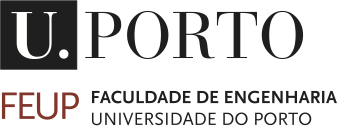   
<h1> <b>Computer Vision 2024/2025 (Assignment 2) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

### **Developed by:**
*   Bernardo de Almeida Soeiro - up202008204
*   Rodrigo de Vasconcelos e Miguel - up202008406
*   Tomás Rosa Carreira - up202007783

FEUP, Dec. 2024

---


# **Proposal 3 - Classification of defects in photovoltaic modules**

Thermal inspection of photovoltaic (PV) modules is a non-invasive technique used to assess
the health and performance of solar panels. By capturing and analyzing the heat signatures
emitted by PV modules, thermal inspections can detect anomalies such as hotspots, dust
accumulation, or damaged cells. Hotspots, in particular, can indicate potential issues like
cell degradation or electrical faults. This proactive approach to maintenance allows for the
early identification of problems, reducing downtime and maximizing the overall efficiency
and lifespan of solar installations. Thermal inspection plays a crucial role in ensuring the
reliability and energy yield of PV systems, making it an essential tool in the field of solar
energy management and maintenance.

**Dataset:**

• Dataset Size: 20000 images.

• Annotations: Each image belongs to one of 12 classes (cell, cell-multi, cracking, hotspot, hot-spot-multi, shadowing, diode, diode-multi, vegetation, soiling, offline-module
and no-anomaly).

• Format: image.jpg and JSON file with image path and respective anomaly label.

# Dataset load and libraries import

In [ ]:
pip install tqdm

In [ ]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=08c3f22a9d9c9b65e4d4550a4689efec9ed0cb71ad845f99c4791624932b8274
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from efficientnet_pytorch import EfficientNet
from torchvision.models import mobilenet_v2

import zipfile
import time
from PIL import Image, ImageFilter, ImageEnhance, ImageChops

import zipfile

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [ ]:
# Clear existing files or directories from previous runs
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

# Define paths for download and extraction
repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clone the repository and extract the zip file
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

# Move images folder to the root directory
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# Move module_metadata.json to the root directory
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

# Verify the final structure
!ls /content


Cloning into '/content/InfraredSolarModules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.49 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (10/10), done.
2020-02-14_InfraredSolarModules.zip  InfraredSolarModules  module_metadata.json
images				     __MACOSX		   sample_data


In [ ]:
# Path to metadata JSON file
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# Preprocessing

Random Original Images



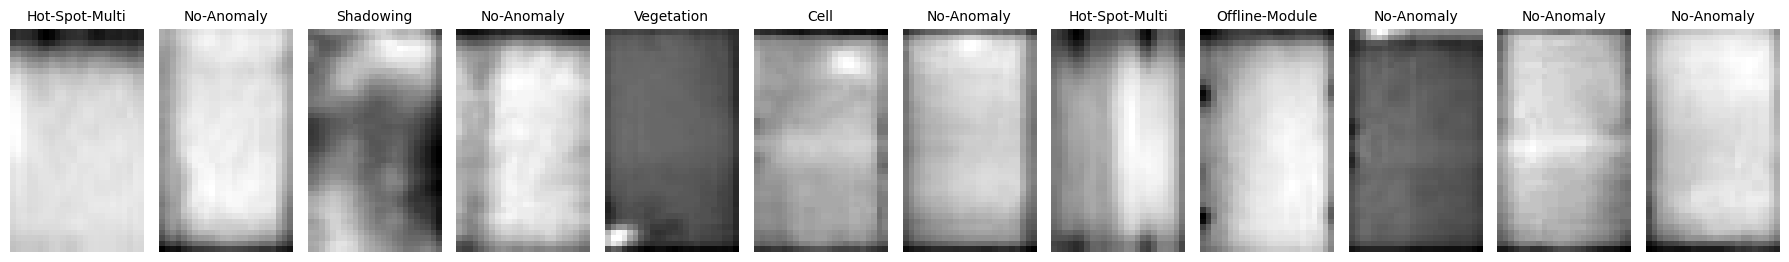

In [ ]:
folder_path = '/content/images'

# List all files in the folder
all_images = [file for file in os.listdir(folder_path) if file.endswith(('jpg'))]

# Randomly select 10 images
random_images = random.sample(all_images, 12)

# Display the selected images
plt.figure(figsize=(18, 10))
print("Random Original Images\n")
for i, image_name in enumerate(random_images):
    img_path = os.path.join(folder_path, image_name)
    img = Image.open(img_path)

    plt.subplot(1, 12, i + 1)  # 2 rows, 5 columns
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Hide axes
    anomaly_label = df.loc[df['image_filepath'] == ('images'+'/'+image_name) , 'anomaly_class'].iloc[0]
    plt.title(anomaly_label, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Create a folder for processed images
processed_folder = '/content/images_preprocessed'
os.makedirs(processed_folder, exist_ok=True)

for image_name in all_images:
    img_path = os.path.join(folder_path, image_name)
    processed_path = os.path.join(processed_folder, image_name)

    img = Image.open(img_path).convert('L')

    smoothed_img = img.filter(ImageFilter.GaussianBlur(radius=2))

    edge_mask = ImageChops.subtract(img, smoothed_img)

    scaling_factor = 0.5
    scaled_edge_mask = edge_mask.point(lambda p: p * scaling_factor)

    sharpened_img = ImageChops.add(img, scaled_edge_mask)

    sharpened_img.save(processed_path)

In [ ]:
df_preprocessed = df.copy()

# Update the paths in the 'image_path' column
if 'image_filepath' in df_preprocessed.columns:
    df_preprocessed['image_filepath'] = df_preprocessed['image_filepath'].str.replace(
        'images/', 'images_preprocessed/', regex=False
    )

Preprocessed Images



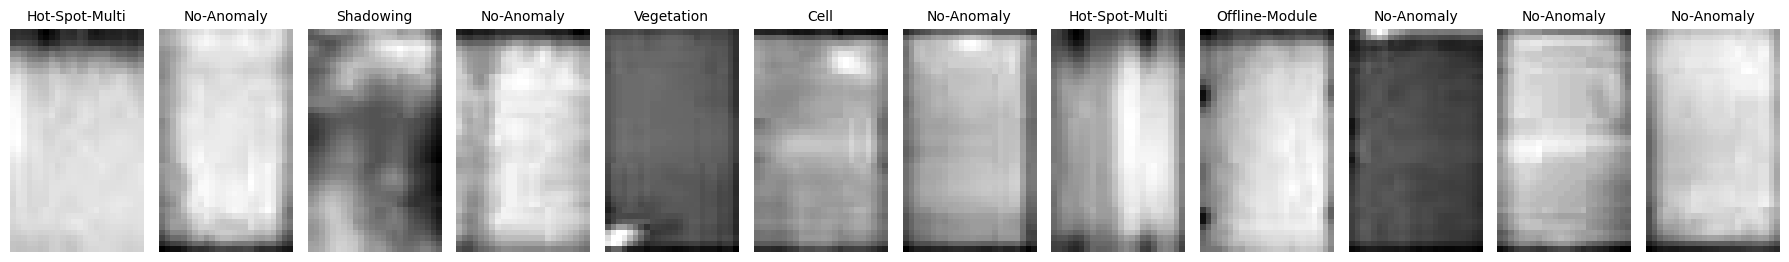

In [ ]:
plt.figure(figsize=(18, 10))
print("Preprocessed Images\n")
for i, image_name in enumerate(random_images):
    processed_path = os.path.join(processed_folder, image_name)
    img = Image.open(processed_path)

    plt.subplot(1, 12, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Hide axes
    preprocessed_path = f'images_preprocessed/{image_name}'
    result = df_preprocessed.loc[df_preprocessed['image_filepath'] == preprocessed_path, 'anomaly_class'].iloc[0]
    plt.title(result, fontsize=10)

plt.tight_layout()
plt.show()

# 1

## a)  Model 1: Binary classification (anomaly or no-anomaly)


**Label assigment and data split**

In [ ]:
df_binary = df_preprocessed.copy()

# Substitution of the labels: anomaly->1 and no_anomaly->0
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

print(df_binary.tail(4))
print("\nDataset size:", df_binary.shape[0])

# Train/Test ratio
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Split into train + test/val
train_data, temp_data = train_test_split(df_binary, test_size=(1 - train_ratio), train_size=train_ratio, random_state=2, stratify=df_binary['anomaly_class'])

# Split validation and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, train_size=0.5, random_state=2, stratify=temp_data['anomaly_class'])

# Reset indices for all splits
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


                      image_filepath  anomaly_class
8489    images_preprocessed/8489.jpg              1
7464    images_preprocessed/7464.jpg              1
18065  images_preprocessed/18065.jpg              0
13354  images_preprocessed/13354.jpg              0

Dataset size: 20000


**Dataset Class**

In [ ]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horizontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    #transforms.RandomRotation(5),                          # Random rotation of 10 degrees
    #transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    transforms.RandomRotation(5),
    transforms.Resize((40, 40)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Augmentation**

In [ ]:
# Initial dataset size
train_data_a_counts = train_data['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_a_counts)
print("\nInitial Size:", len(train_data), "\n")

train_data_a_balanced = train_data.copy()

# Folder creation for new images
directory = "/content/images_a"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data)):
    row = train_data.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    # Perform augmentations
    n1 = random.randint(0, 2)
    n2 = random.randint(0, 2)

    while n2 == n1:
      n2 = random.randint(0, 2)
    for j in range(2):
      if(j==0):
        if(n1==0):
          transform_augmentation = transform_augmentation_1
        if(n1==1):
          transform_augmentation = transform_augmentation_2
        if(n1==2):
          transform_augmentation = transform_augmentation_3
      if(j==1):
        if(n2==0):
          transform_augmentation = transform_augmentation_1
        if(n2==1):
          transform_augmentation = transform_augmentation_2
        if(n2==2):
          transform_augmentation = transform_augmentation_3

      transformed_image = transform_augmentation(image_pil)
      if isinstance(transformed_image, torch.Tensor):
          transformed_image = transforms.ToPILImage()(transformed_image)
      new_image_path = os.path.join(directory, f"transformed_image_{i}_{j}.jpg")
      transformed_image.save(new_image_path, format="JPEG", quality=95)
      new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
      train_data_a_balanced = pd.concat([train_data_a_balanced, pd.DataFrame([new_row])], ignore_index=True)

# Final dataset size
train_data_a_balanced_counts = train_data_a_balanced['anomaly_class'].value_counts()
print("\n\nCount of each anomaly type(Augmented):")
print(train_data_a_balanced_counts)
print("\nAugmented Size:", len(train_data_a_balanced))

Counts of each anomaly type(Initial):
anomaly_class
0    8000
1    8000
Name: count, dtype: int64

Initial Size: 16000 



Count of each anomaly type(Augmented):
anomaly_class
0    24000
1    24000
Name: count, dtype: int64

Augmented Size: 48000


**Dataloaders**

In [ ]:
# Create the datasets for train, validation, and test
train_dataset = MyImageDataset(metadata=train_data_a_balanced, transform=train_transform)
val_dataset = MyImageDataset(metadata=val_data, transform=test_transform)  # Use test_transform for validation (same as test)
test_dataset = MyImageDataset(metadata=test_data, transform=test_transform)

batch_size = 16
# Create DataLoader for each dataset
train_loader_a = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader_a = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader_a = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Image Size:  torch.Size([1, 40, 40])


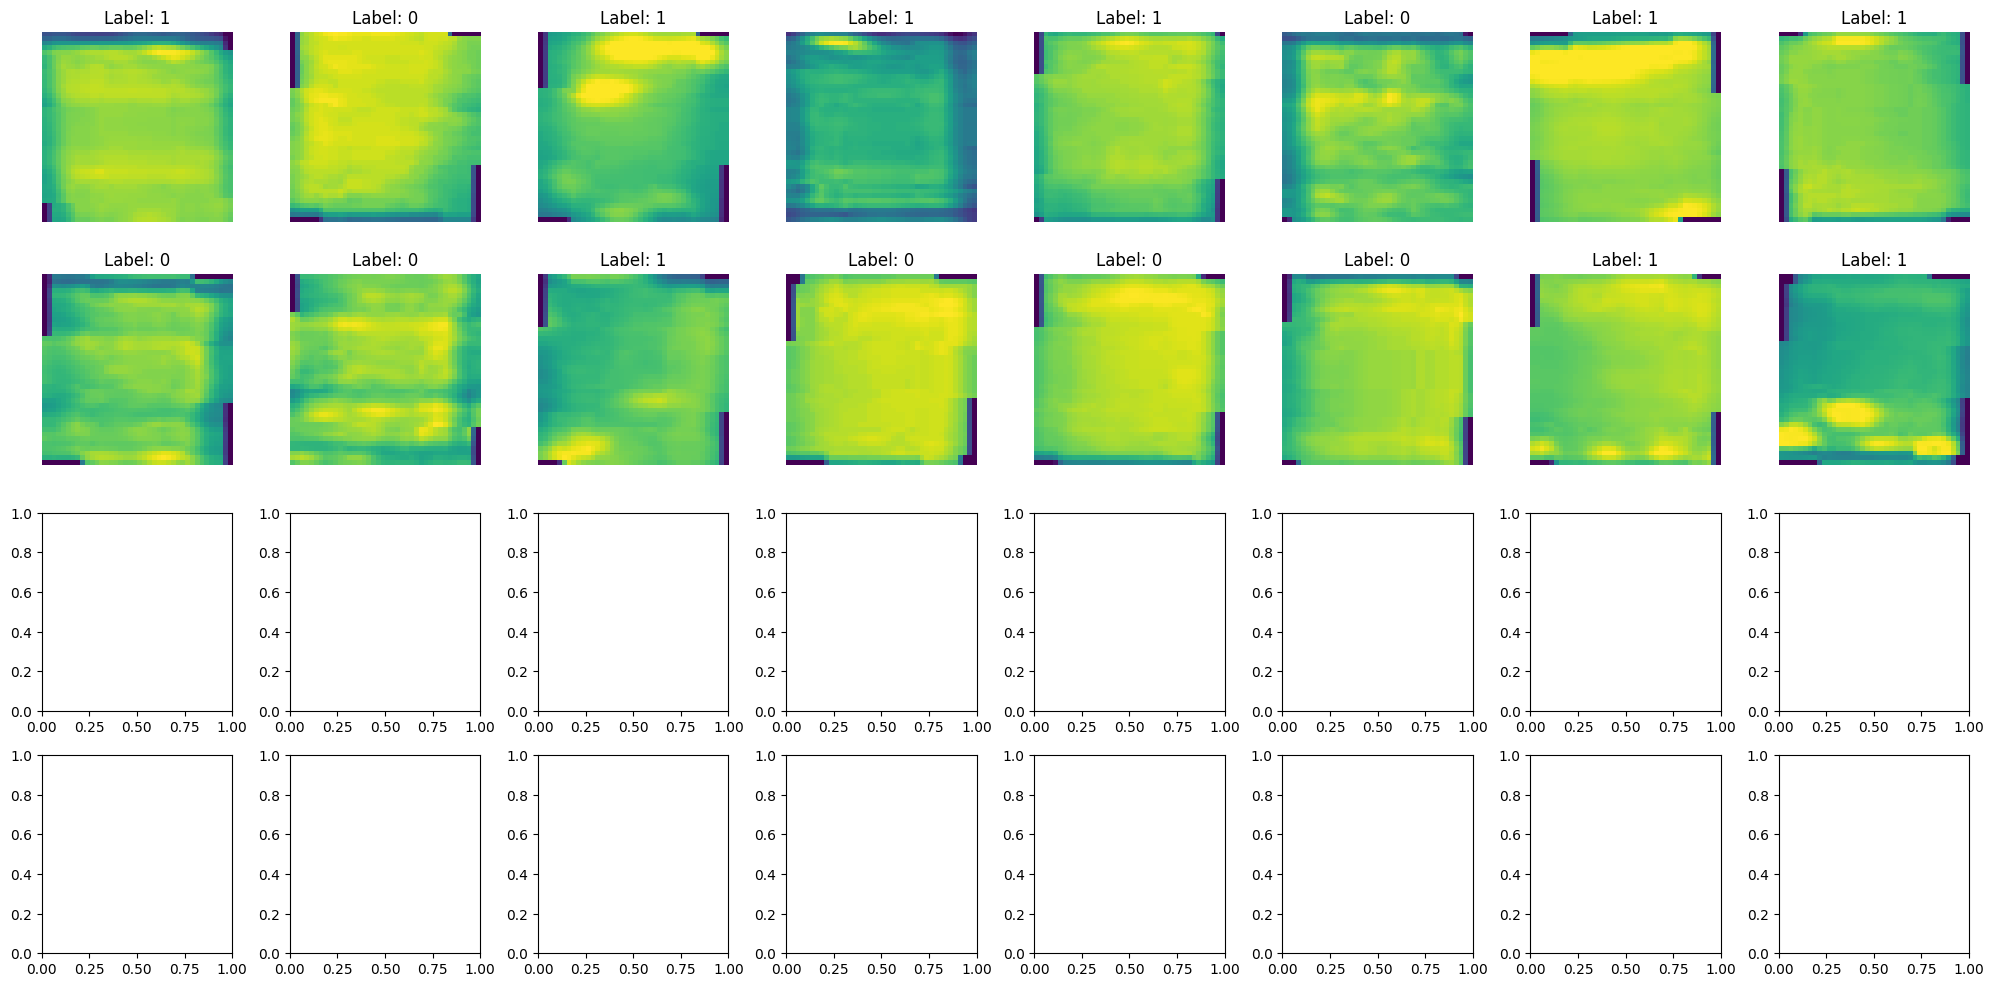

In [ ]:
# Show of 32 images
images, labels = next(iter(train_loader_a))

# Inverse of normalization
images = images * 0.5 + 0.5
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images)):
    image = images[i]
    image_pil = transforms.ToPILImage()(image)

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

print("Image Size: ", images[0].shape)
plt.tight_layout()
plt.show()

**Convolutional Neural Network**

In [ ]:
class Network_a(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # Input: (40x40x1), Output: (40x40x32)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # Output: (20x20x32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # Output: (20x20x64)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # Output: (10x10x64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # Output: (10x10x128)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # Output: (5x5x128)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)  # Binary classification, 1 output neuron for sigmoid activation

    def forward(self, x):
        # Convolutional layers with ReLU, batch normalization, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

# Instantiate the model
model_a = Network_a()

# Define the loss function and optimizer
loss_fn_a = nn.BCEWithLogitsLoss()  # For binary classification
optimizer_a = torch.optim.Adam(model_a.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_a = ReduceLROnPlateau(optimizer_a, mode='min', factor=0.2, patience=5)

**Train and Test functions**

In [ ]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device):
    best_model = None
    best_val_acc = 0
    for epoch in range(num_epochs):
        start_time = time.time()  # Start timing the epoch

        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)  # Outputs are raw logits
            loss = loss_fn(outputs.squeeze(), labels.float())  # Match dimensions for binary classification
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs.squeeze()) >= 0.5).float()  # Threshold logits to get predictions
            train_acc += (preds == labels).sum().item() / len(labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)  # Outputs are raw logits
                loss = loss_fn(outputs.squeeze(), labels.float())  # Match dimensions for binary classification

                val_loss += loss.item()
                preds = (torch.sigmoid(outputs.squeeze()) >= 0.5).float()  # Threshold logits to get predictions
                val_acc += (preds == labels).sum().item() / len(labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

        # Store values for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Update learning rate scheduler
        scheduler.step(val_loss)

        end_time = time.time()  # End timing the epoch
        epoch_time = end_time - start_time  # Calculate elapsed time

        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

    # Return the best model
    model.load_state_dict(best_model)
    return model

In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    model.eval()      # | Put model in evaluation mode
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            y_pred = model(images)                    # | 1. Make predictions

            loss = loss_fn(y_pred.squeeze(), labels.float())  # Match dimensions
            test_loss += loss.item()                  # |

            y_pred_class = (torch.sigmoid(y_pred.squeeze()) >= 0.5).float()  # | 3. Threshold predictions
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)  # |

            pred_labels.extend(y_pred_class.tolist())                             # | Accumulate predictions and true labels
            true_labels.extend(labels.tolist())                                   # |

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')  # Use 'weighted' for class imbalance

    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")

    return pred_labels, test_loss, test_acc, f1

**Train**

Epoch 0/75 - Train Loss: 0.4999, Train Acc: 0.7554, Val Loss: 0.4008, Val Acc: 0.8260, Time: 59.60s
Epoch 1/75 - Train Loss: 0.3927, Train Acc: 0.8279, Val Loss: 0.3382, Val Acc: 0.8630, Time: 57.37s
Epoch 2/75 - Train Loss: 0.3618, Train Acc: 0.8460, Val Loss: 0.3150, Val Acc: 0.8755, Time: 58.41s
Epoch 3/75 - Train Loss: 0.3381, Train Acc: 0.8579, Val Loss: 0.3144, Val Acc: 0.8740, Time: 58.52s
Epoch 4/75 - Train Loss: 0.3261, Train Acc: 0.8629, Val Loss: 0.3104, Val Acc: 0.8700, Time: 58.69s
Epoch 5/75 - Train Loss: 0.3142, Train Acc: 0.8698, Val Loss: 0.2787, Val Acc: 0.8865, Time: 58.52s
Epoch 6/75 - Train Loss: 0.3045, Train Acc: 0.8734, Val Loss: 0.2750, Val Acc: 0.8855, Time: 58.53s
Epoch 7/75 - Train Loss: 0.2962, Train Acc: 0.8790, Val Loss: 0.2835, Val Acc: 0.8835, Time: 58.28s
Epoch 8/75 - Train Loss: 0.2888, Train Acc: 0.8831, Val Loss: 0.2592, Val Acc: 0.8970, Time: 57.86s
Epoch 9/75 - Train Loss: 0.2774, Train Acc: 0.8874, Val Loss: 0.2639, Val Acc: 0.9010, Time: 57.66s


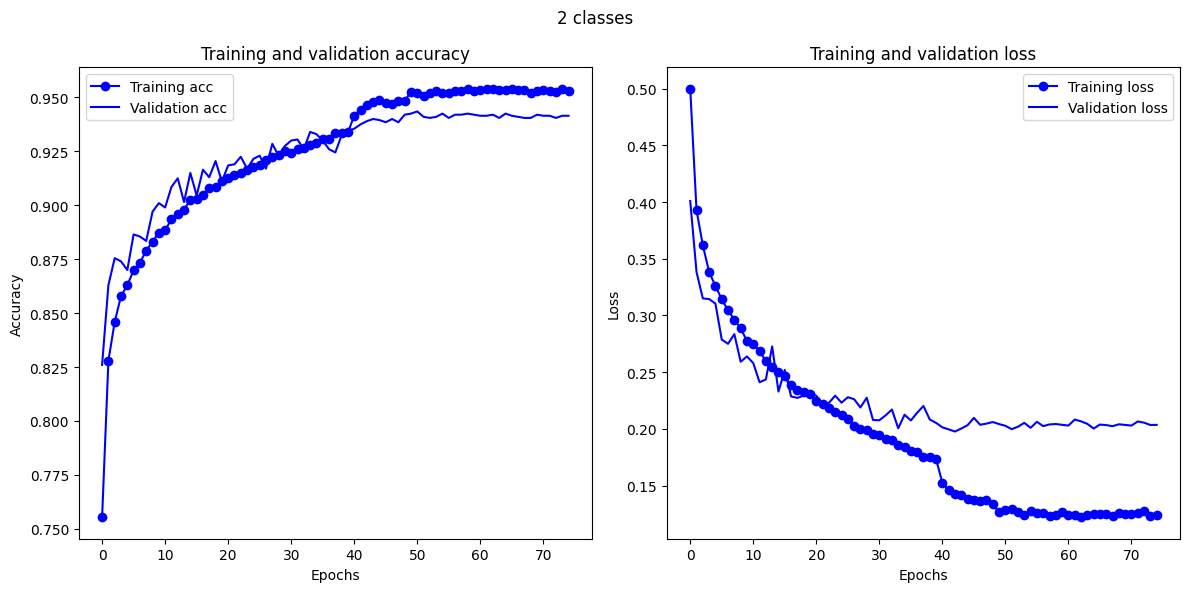

In [ ]:
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model_a.to(device)

best_model = train_and_validate(model_a,
                                train_loader_a,
                                val_loader_a,
                                loss_fn_a,
                                optimizer_a,
                                scheduler_a,
                                num_epochs=75,
                                device=device)

path_model = str("./myModel_best_a.pth")
path = path_model
saveModel(model_a, path=path)



# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, 'bo-', label='Training acc')
plt.plot(val_accuracies, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, 'bo-', label='Training loss')
plt.plot(val_losses, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("2 classes")  # Title for both plots
plt.tight_layout()
plt.show()


**Test**

Loss = 0.1844, F1-Score = 0.9480, Accuracy = 0.9480


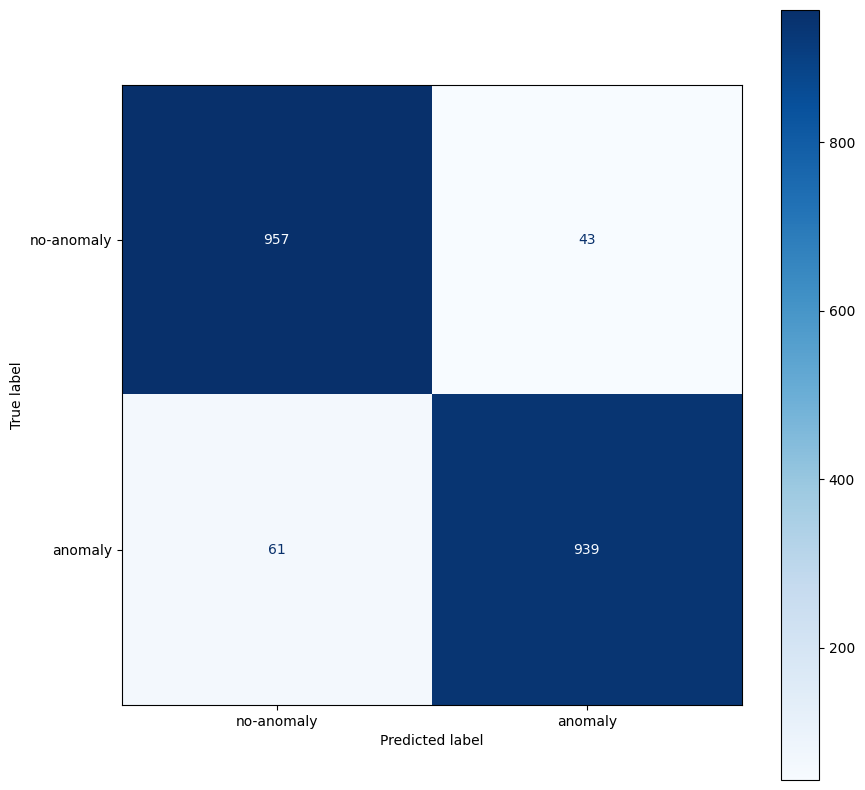

In [ ]:
# Load the model
model_a_test = Network_a()
model_a_test = model_a_test.to(device)
saved_model_path = "./myModel_best_a.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model_a_test.load_state_dict(checkpoint)
model_a_test.eval()

# Perform testing
y_pred_a, test_loss_a, test_acc_a, f1_score_a = test( model=model_a_test,
                                                      dataloader=test_loader_a,
                                                      loss_fn=loss_fn_a,
                                                      device=device,
                                                      verbatim=True)

# Define the confusion matrix plotting function
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

# Plot the confusion matrix
class_names_a = ['no-anomaly', 'anomaly']
plot_confusion_matrix(test_dataset.img_labels, y_pred_a, class_names_a)


## b) Model 2: Classification with 11 anomaly classes (cell, cell-multi, cracking, hotspot, hot-spot-multi, shadowing, diode, diode-multi, vegetation, soiling and offlinemodule)

**Lables assigment and data split**

In [ ]:
df_anomaly = df_preprocessed.copy()

# Filter out the "No-Anomaly" class
df_anomaly = df_anomaly[df_anomaly["anomaly_class"] != "No-Anomaly"]

# Substitution of label to a number
df_anomaly['anomaly_class'] = df_anomaly['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)

# Print the class distribution
anomaly_counts = df_anomaly['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(anomaly_counts)

# Train/Test ratio
train_ratio_b = 0.8
val_ratio_b = 0.1
test_ratio_b = 0.1

# Split into train + test/val
train_data_b, temp_data_b = train_test_split(df_anomaly, test_size=(1 - train_ratio_b), train_size=train_ratio_b, random_state=2, stratify=df_anomaly['anomaly_class'])

# Split validation and test
val_data_b, test_data_b = train_test_split(temp_data_b, test_size=0.5, train_size=0.5, random_state=2, stratify=temp_data_b['anomaly_class'])

# Reset indices for all splits
train_data_b.reset_index(drop=True, inplace=True)
val_data_b.reset_index(drop=True, inplace=True)
test_data_b.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
0     1877
8     1639
6     1499
1     1288
5     1056
2      940
10     827
3      249
4      246
9      204
7      175
Name: count, dtype: int64


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=(0.2, 0.5)),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ColorJitter(brightness=(0.2, 0.5)),
    transforms.ToTensor(),
])

# Vertical and horizontal flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=(0.2, 0.5)),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    #transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    #transforms.ColorJitter(brightness=(0.2, 1.2))            # Color jitter
    transforms.Resize((40, 40)),                            # Resize
    transforms.RandomRotation(5),
    transforms.RandomCrop((40, 40), padding=1),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Augmentation**

In [ ]:
train_data_b_counts = train_data_b['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_b_counts)
print("\nInitial Size:", len(train_data_b), "\n")

train_data_b_balanced = train_data_b.copy()

largest_class_count = train_data_b_counts.max()                  #
ratios = largest_class_count / train_data_b_counts               #
max_ratio = 4                                                    #
ratios += 0.5
ratios = np.minimum(ratios, max_ratio)                           #
ratios_sorted = ratios.sort_index()                              #
ratios_matrix=[]                                                 # Ratios Calculations
                                                                 #
for label, ratio in ratios_sorted.items():                       #
    ratios_matrix.append([label, ratio])                         #                                        #
print(ratios_matrix)                                             #



directory = "/content/images_b"                                  #
if os.path.exists(directory):                                    #
    for filename in os.listdir(directory):                       #
        file_path = os.path.join(directory, filename)            #
        try:                                                     #
            if os.path.isdir(file_path):                         #
              shutil.rmtree(file_path)                           # Folder creation for new images
            else:                                                #
                os.remove(file_path)                             #
        except Exception as e:                                   #
            print(f"Error deleting file {file_path}: {e}")       #
else:                                                            #
    os.makedirs(directory, exist_ok=True)                        #


#Augmentation
for i in range(len(train_data_b)):
    row = train_data_b.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        random_number = random.randint(1, 3)
        if(int_part==1):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==0):
            if(num1==1):
                transform_augmentation = transform_augmentation_1
            elif(num1==2):
                transform_augmentation = transform_augmentation_2
            elif(num1==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==1):
            if(num2==1):
                transform_augmentation = transform_augmentation_1
            elif(num2==2):
                transform_augmentation = transform_augmentation_2
            elif(num2==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==3 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==3 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==3 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==4 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==4 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==3):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)

    # Perform probabilistic augmentation for the fractional part
    if random.random() < frac_part:
        random_number = random.randint(1, 3)
        if(random_number==1):
            transform_augmentation = transform_augmentation_1
        elif(random_number==2):
            transform_augmentation = transform_augmentation_2
        elif(random_number==3):
            transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        x=1
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_2_{int(label)}_{i}_{x}.jpg")
        x+=1
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_b_balanced_counts = train_data_b_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_b_balanced_counts)
print("\nAugmented Size:", len(train_data_b_balanced))

Counts of each anomaly type(Initial):
anomaly_class
0     1502
8     1311
6     1199
1     1030
5      845
2      752
10     662
3      199
4      197
9      163
7      140
Name: count, dtype: int64

Initial Size: 8000 

[[0, 1.5], [1, 1.9582524271844661], [2, 2.497340425531915], [3, 4.0], [4, 4.0], [5, 2.2775147928994084], [6, 1.7527105921601334], [7, 4.0], [8, 1.6456903127383677], [9, 4.0], [10, 2.768882175226586]]


Counts of each anomaly type(Augmented):
anomaly_class
0     2303
8     2152
6     2077
1     2011
5     1917
2     1891
10    1848
3      796
4      788
9      652
7      560
Name: count, dtype: int64

Augmented Size: 16995


**Dataset class**

In [ ]:
class MyImageDataset_b(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Dataloaders**

In [ ]:
# Create the datasets for train, validation, and test
train_dataset_b = MyImageDataset_b(metadata=train_data_b_balanced, transform=train_transform)
val_dataset_b = MyImageDataset_b(metadata=val_data_b, transform=test_transform)  # Use test_transform for validation (same as test)
test_dataset_b = MyImageDataset_b(metadata=test_data_b, transform=test_transform)

batch_size = 16
# Create DataLoader for each dataset
train_loader_b = data.DataLoader(dataset=train_dataset_b, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_b = data.DataLoader(dataset=val_dataset_b, batch_size=batch_size, shuffle=False)
test_loader_b = data.DataLoader(dataset=test_dataset_b, batch_size=batch_size, shuffle=False)

tensor(10)
torch.Size([1, 40, 40])


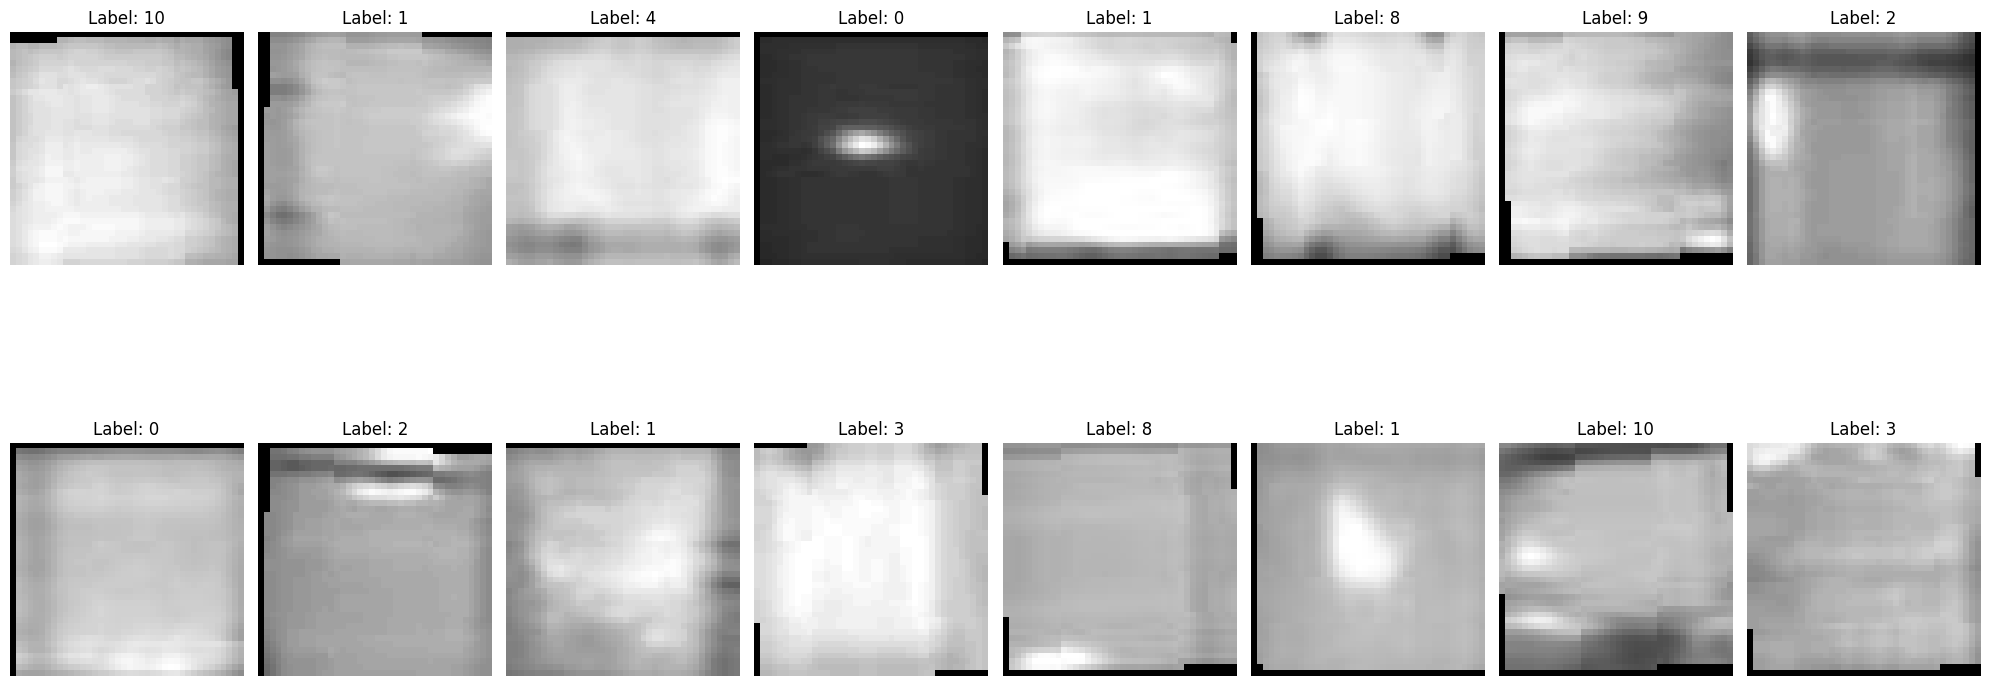

In [ ]:
# Show a batch
images_b, labels_b = next(iter(train_loader_b))
print(labels_b[0])

images_b = images_b * 0.5 + 0.5

fig, axes = plt.subplots(2, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_b)):
    image = images_b[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil, cmap='gray')
    axes[i].set_title(f"Label: {labels_b[i].item()}")
    axes[i].axis('off')
print(images_b[0].shape)
plt.tight_layout()
plt.show()

**Train and test functions**

In [ ]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device):
    best_model = None
    best_val_acc = 0
    for epoch in range(num_epochs):
        start_time = time.time()  # Start timing the epoch

        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item() / len(labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += (preds == labels).sum().item() / len(labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

        # Store values for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Update learning rate scheduler
        scheduler.step(val_loss)

        end_time = time.time()  # End timing the epoch
        epoch_time = end_time - start_time  # Calculate elapsed time

        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

    # Return the best model
    model.load_state_dict(best_model)
    return model


In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    model.eval()      # | Put model in evaluation mode
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            y_pred = model(images)                    # | 1. Make predictions

            loss = loss_fn(y_pred, labels)            # | 2. Calculate loss
            test_loss += loss.item()                  # |

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)      # | 3. Calculate accuracy
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)       # |

            pred_labels.extend(y_pred_class.tolist())                             # | Accumulate predictions and true labels
            true_labels.extend(labels.tolist())                                   # |

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')  # Use 'weighted' for class imbalance

    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")

    return pred_labels, test_loss, test_acc, f1

**Convolution Neural Network**

In [ ]:
class Network_b(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(256, 512, 3)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(512, 512, 1)  # Extra layer
        self.bn4 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 40)
        # After conv1: (38, 38)
        # After pool1: (19, 19)
        # After conv2: (17, 17)
        # After pool2: (8, 8)
        # After conv3: (6, 6)
        # After pool3: (3, 3)
        # After conv4: (3, 3)

        self.fc1 = nn.Linear(512 * 3 * 3, 2048)
        self.bn_fc1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn_fc2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 256)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(256, 11)

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout_conv(x)  # Dropout after conv layers
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)

        return x

model_b = Network_b()

class_labels = train_data_b_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn_b = nn.CrossEntropyLoss(weight=class_weights).to(device)

optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_b = ReduceLROnPlateau(optimizer_b, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


**Train**

Epoch 0/50 - Train Loss: 2.3168, Train Acc: 0.1624, Val Loss: 2.0783, Val Acc: 0.3026, Time: 25.71s
Epoch 1/50 - Train Loss: 2.0585, Train Acc: 0.2641, Val Loss: 1.7748, Val Acc: 0.4127, Time: 26.39s
Epoch 2/50 - Train Loss: 1.7974, Train Acc: 0.3593, Val Loss: 1.4951, Val Acc: 0.4683, Time: 25.63s
Epoch 3/50 - Train Loss: 1.5947, Train Acc: 0.4303, Val Loss: 1.3182, Val Acc: 0.5298, Time: 26.42s
Epoch 4/50 - Train Loss: 1.4706, Train Acc: 0.4756, Val Loss: 1.2562, Val Acc: 0.5357, Time: 25.81s
Epoch 5/50 - Train Loss: 1.4033, Train Acc: 0.4902, Val Loss: 1.2075, Val Acc: 0.5704, Time: 25.67s
Epoch 6/50 - Train Loss: 1.3344, Train Acc: 0.5146, Val Loss: 1.1231, Val Acc: 0.6002, Time: 26.46s
Epoch 7/50 - Train Loss: 1.2970, Train Acc: 0.5257, Val Loss: 1.0775, Val Acc: 0.6151, Time: 26.46s
Epoch 8/50 - Train Loss: 1.2467, Train Acc: 0.5406, Val Loss: 1.0302, Val Acc: 0.6339, Time: 26.24s
Epoch 9/50 - Train Loss: 1.2165, Train Acc: 0.5481, Val Loss: 1.0294, Val Acc: 0.6270, Time: 25.00s


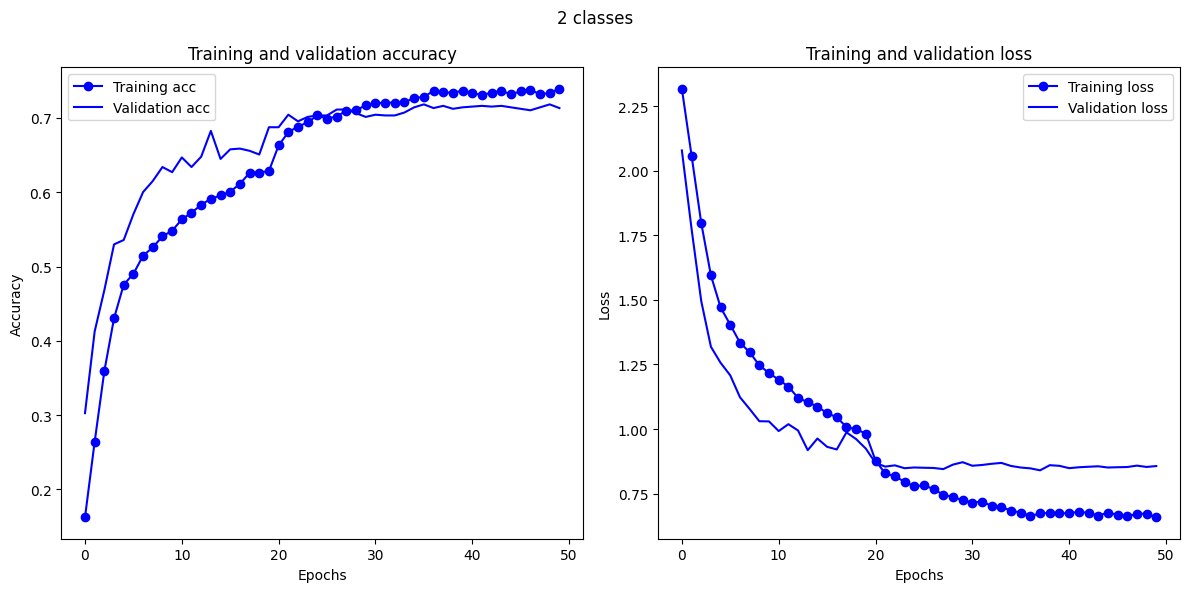

In [ ]:
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model_b.to(device)

best_model = train_and_validate(model_b,
                                train_loader_b,
                                val_loader_b,
                                loss_fn_b,
                                optimizer_b,
                                scheduler_b,
                                num_epochs=50,
                                device=device)

path_model = str("./myModel_best_A_b.pth")
path = path_model
saveModel(model_b, path=path)



# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, 'bo-', label='Training acc')
plt.plot(val_accuracies, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, 'bo-', label='Training loss')
plt.plot(val_losses, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("2 classes")  # Title for both plots
plt.tight_layout()
plt.show()


**Test**

Loss = 0.8678, F1-Score = 0.6889, Accuracy = 0.6925


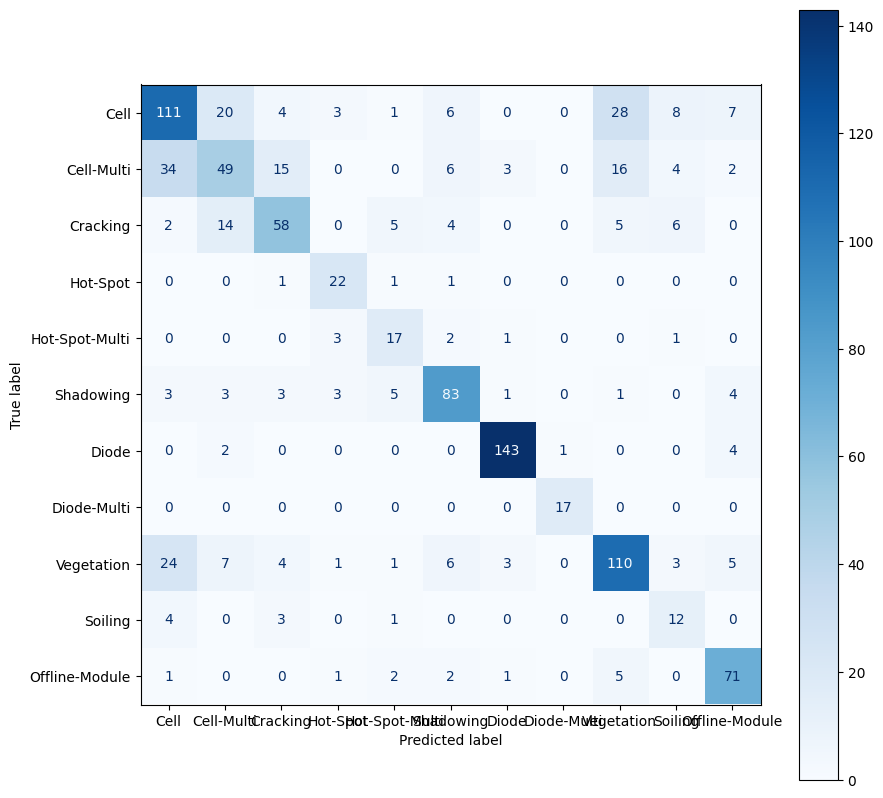

In [ ]:
model_b_test = Network_b()
model_b_test = model_b_test.to(device)
saved_model_path = "./myModel_best_A_b.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model_b_test.load_state_dict(checkpoint)
model_b_test.eval()

# Perform testing
y_pred_b, test_loss_b, test_acc_b, f1_score_b = test( model=model_b_test,
                                                      dataloader=test_loader_b,
                                                      loss_fn=loss_fn_b,
                                                      device=device,
                                                      verbatim=True)

def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()


# Plot the confusion matrix
class_names_b = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module']
plot_confusion_matrix(test_dataset_b.img_labels, y_pred_b, class_names_b)

## c)  Model 3: Classification with 12 classes (cell, cell-multi, cracking, hot-spot, hotspot-multi, shadowing, diode, diode-multi, vegetation, soiling, offline-module and no-anomaly)

**Lable assigment and data split**

In [ ]:
# Binary Classification DataFrame
df_all_classes = df_preprocessed.copy()

# Substitution of string lables to numeric
df_all_classes['anomaly_class'] = df_all_classes['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)

# Class distribution
df_all_classes_count = df_all_classes['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(df_all_classes_count)

#Train/Test ratio and split
train_ratio_c = 0.9

train_data_c, temp_data_c = train_test_split(df_all_classes, test_size=(1 - train_ratio_c), train_size=train_ratio_c, random_state=2, stratify=df_all_classes['anomaly_class'])
val_data_c, test_data_c = train_test_split(temp_data_c, test_size=0.5, train_size=0.5, random_state=2, stratify=temp_data_c['anomaly_class'])

# Reset indices for all splits
train_data_c.reset_index(drop=True, inplace=True)
val_data_c.reset_index(drop=True, inplace=True)
test_data_c.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
11    10000
0      1877
8      1639
6      1499
1      1288
5      1056
2       940
10      827
3       249
4       246
9       204
7       175
Name: count, dtype: int64


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horizontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    #transforms.RandomRotation(5),                          # Random rotation of 10 degrees
    #transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    transforms.Resize((40, 40)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Augmentation**

In [ ]:
train_data_c_counts = train_data_c['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_c_counts)
print("\nInitial Size:", len(train_data_c), "\n")

# Datasets
train_data_c_balanced = train_data_c.copy()

largest_class_count = train_data_c_counts.max()                     #
ratios = largest_class_count / train_data_c_counts                  #
max_ratio = 4                                                       #
ratios = np.minimum(ratios, max_ratio)                              #
ratios_sorted = ratios.sort_index()                                 # Ratios Calculations
ratios_matrix=[]                                                    #
for label, ratio in ratios_sorted.items():                          #
    ratios_matrix.append([label, ratio])                            #
print(ratios_matrix)                                                #



directory = "/content/images_c"                                     #
if os.path.exists(directory):                                       #
    for filename in os.listdir(directory):                          #
        file_path = os.path.join(directory, filename)               #
        try:                                                        #
            if os.path.isdir(file_path):                            #
                shutil.rmtree(file_path)                            # Folder creation for new images
            else:                                                   #
                os.remove(file_path)                                #
        except Exception as e:                                      #
            print(f"Error deleting file {file_path}: {e}")          #
else:                                                               #
    os.makedirs(directory, exist_ok=True)                           #


# Augmentation
for i in range(len(train_data_c)):
    row = train_data_c.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        if(n==0):
            transform_augmentation = transform_augmentation_1
        elif(n==1):
            transform_augmentation = transform_augmentation_2
        elif(n==2):
            transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_c_balanced = pd.concat([train_data_c_balanced, pd.DataFrame([new_row])], ignore_index=True)

train_data_c_balanced_counts = train_data_c_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_c_balanced_counts)
print("\nAugmented Size:", len(train_data_c_balanced))

Counts of each anomaly type(Initial):
anomaly_class
11    9000
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64

Initial Size: 18000 

[[0, 4.0], [1, 4.0], [2, 4.0], [3, 4.0], [4, 4.0], [5, 4.0], [6, 4.0], [7, 4.0], [8, 4.0], [9, 4.0], [10, 4.0], [11, 1.0]]


Counts of each anomaly type(Augmented):
anomaly_class
11    9000
0     6756
8     5900
6     5396
1     4636
5     3800
2     3384
10    2976
3      896
4      888
9      736
7      632
Name: count, dtype: int64

Augmented Size: 45000


**Image dataset class**

In [ ]:
class MyImageDataset_c(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Data loaders**

In [ ]:
# Create the datasets for train, validation, and test
train_dataset_c = MyImageDataset_c(metadata=train_data_c_balanced, transform=train_transform)
val_dataset_c = MyImageDataset_c(metadata=val_data_c, transform=test_transform)
test_dataset_c = MyImageDataset_c(metadata=test_data_c, transform=test_transform)

batch_size_c = 32
# Create DataLoader for each dataset
train_loader_c = data.DataLoader(dataset=train_dataset_c, batch_size=batch_size_c, shuffle=True, drop_last=True)
val_loader_c = data.DataLoader(dataset=val_dataset_c, batch_size=batch_size_c, shuffle=False)
test_loader_c = data.DataLoader(dataset=test_dataset_c, batch_size=batch_size_c, shuffle=False)


Image size torch.Size([1, 40, 40])


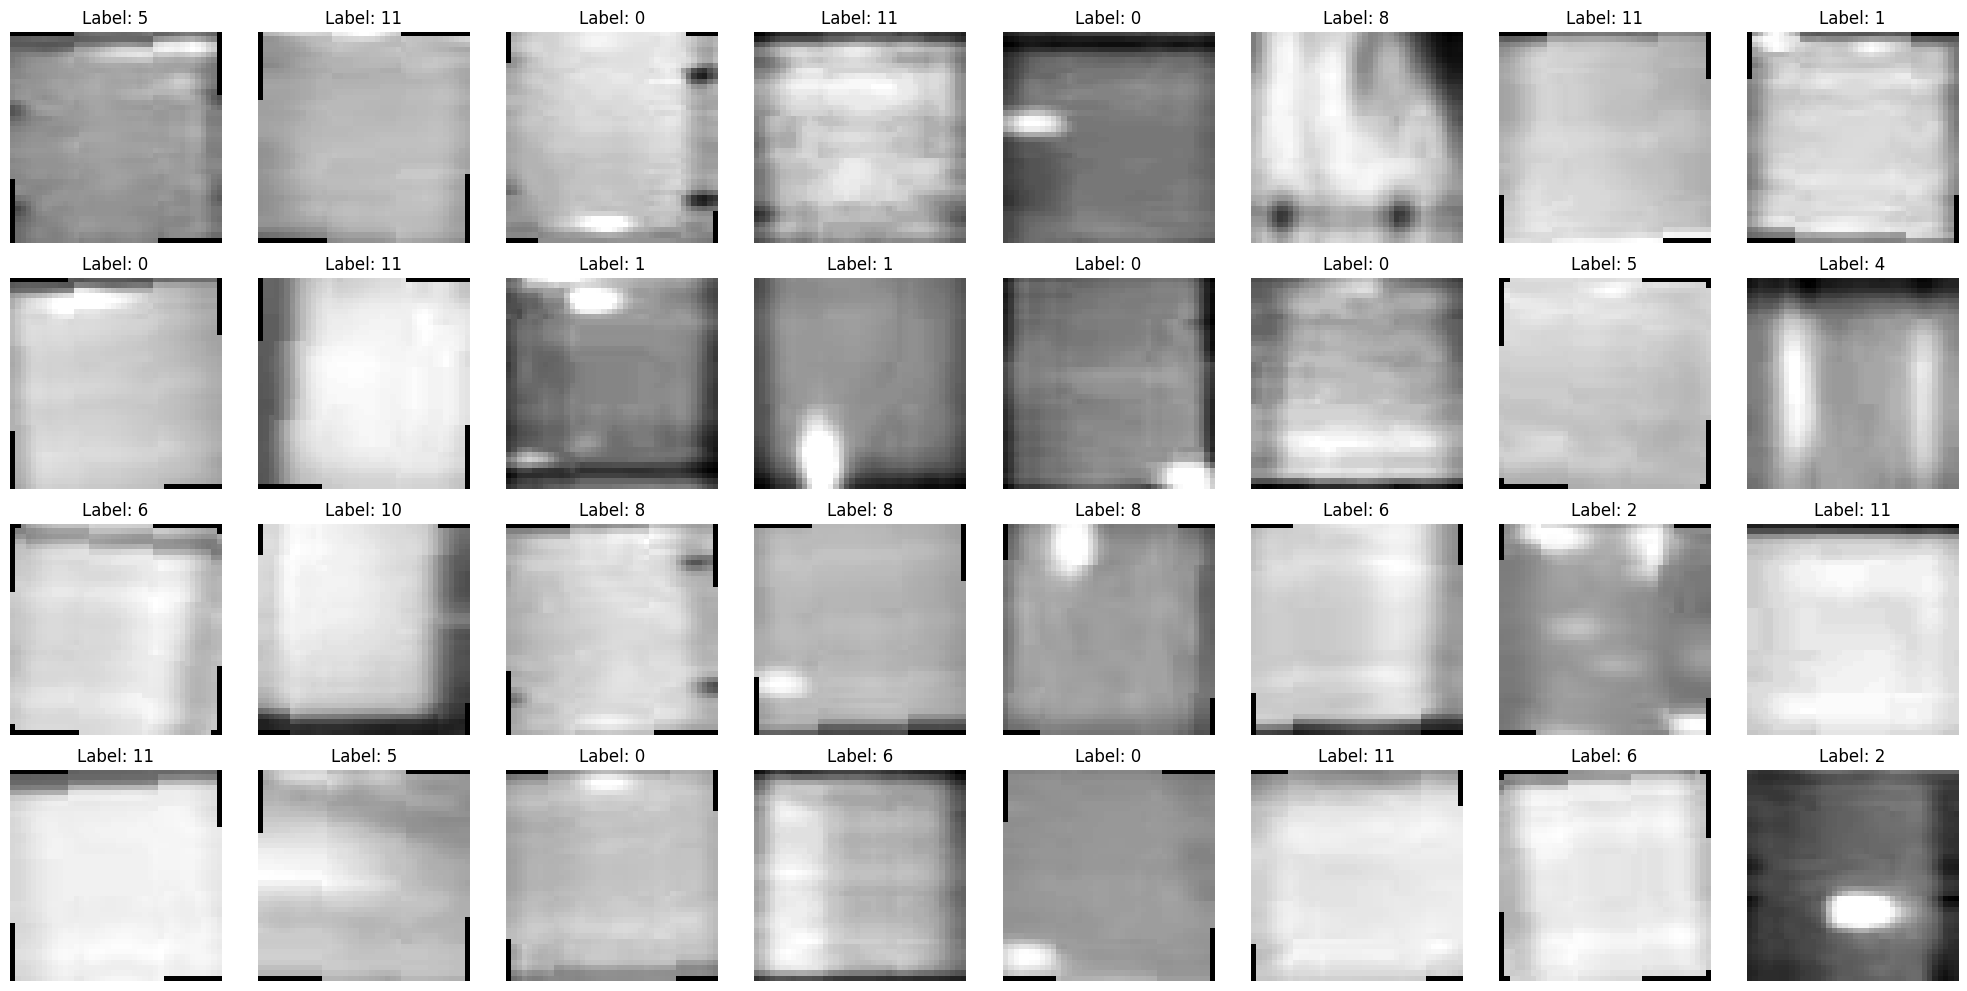

In [ ]:
# Show of a batch
images_c, labels_c = next(iter(train_loader_c))
images_c = images_c * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_c)):
    image = images_c[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil, cmap='gray')
    axes[i].set_title(f"Label: {labels_c[i].item()}")
    axes[i].axis('off')

print("Image size", images_c[0].shape)
plt.tight_layout()
plt.show()

**Train and test functions**

In [ ]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device):
    best_model = None
    best_val_acc = 0
    for epoch in range(num_epochs):
        start_time = time.time()  # Start timing the epoch

        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item() / len(labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += (preds == labels).sum().item() / len(labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

        # Store values for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Update learning rate scheduler
        scheduler.step(val_loss)

        end_time = time.time()  # End timing the epoch
        epoch_time = end_time - start_time  # Calculate elapsed time

        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

    # Return the best model
    model.load_state_dict(best_model)
    return model


In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    model.eval()      # Put model in evaluation mode
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)  # Make predictions

            loss = loss_fn(y_pred, labels)  # Calculate loss
            test_loss += loss.item()

            _, y_pred_class = torch.max(y_pred, 1)  # Get the class with the max score
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            pred_labels.extend(y_pred_class.tolist())  # Accumulate predictions and true labels
            true_labels.extend(labels.tolist())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')  # Use 'weighted' for class imbalance

    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")

    return pred_labels, test_loss, test_acc, f1


**Convolutional Neural Network**

In [ ]:
class Network_c(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  # Increase filters
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)  # New layer
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.dropout_conv = nn.Dropout2d(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)  # Adjust input dimensions
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, 12)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout_conv(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Instantiate the model
model_c = Network_c()

class_labels = train_data_c_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn_c = nn.CrossEntropyLoss(weight=class_weights).to(device)

optimizer_c = torch.optim.Adam(model_c.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_c = ReduceLROnPlateau(optimizer_c, mode='min', factor=0.2, patience=5)

**Train**

Epoch 0/100 - Train Loss: 2.3131, Train Acc: 0.1962, Val Loss: 1.9864, Val Acc: 0.3887, Time: 55.03s
Epoch 1/100 - Train Loss: 1.9889, Train Acc: 0.2931, Val Loss: 1.6506, Val Acc: 0.4834, Time: 52.50s
Epoch 2/100 - Train Loss: 1.7989, Train Acc: 0.3565, Val Loss: 1.4944, Val Acc: 0.5225, Time: 52.21s
Epoch 3/100 - Train Loss: 1.6776, Train Acc: 0.3933, Val Loss: 1.3978, Val Acc: 0.5254, Time: 52.83s
Epoch 4/100 - Train Loss: 1.5864, Train Acc: 0.4262, Val Loss: 1.2943, Val Acc: 0.5430, Time: 53.31s
Epoch 5/100 - Train Loss: 1.5260, Train Acc: 0.4465, Val Loss: 1.2709, Val Acc: 0.5254, Time: 52.02s
Epoch 6/100 - Train Loss: 1.4613, Train Acc: 0.4680, Val Loss: 1.1997, Val Acc: 0.5645, Time: 52.45s
Epoch 7/100 - Train Loss: 1.4186, Train Acc: 0.4819, Val Loss: 1.1871, Val Acc: 0.5762, Time: 51.80s
Epoch 8/100 - Train Loss: 1.3804, Train Acc: 0.4957, Val Loss: 1.1039, Val Acc: 0.6064, Time: 52.67s
Epoch 9/100 - Train Loss: 1.3475, Train Acc: 0.5058, Val Loss: 1.0750, Val Acc: 0.6299, Tim

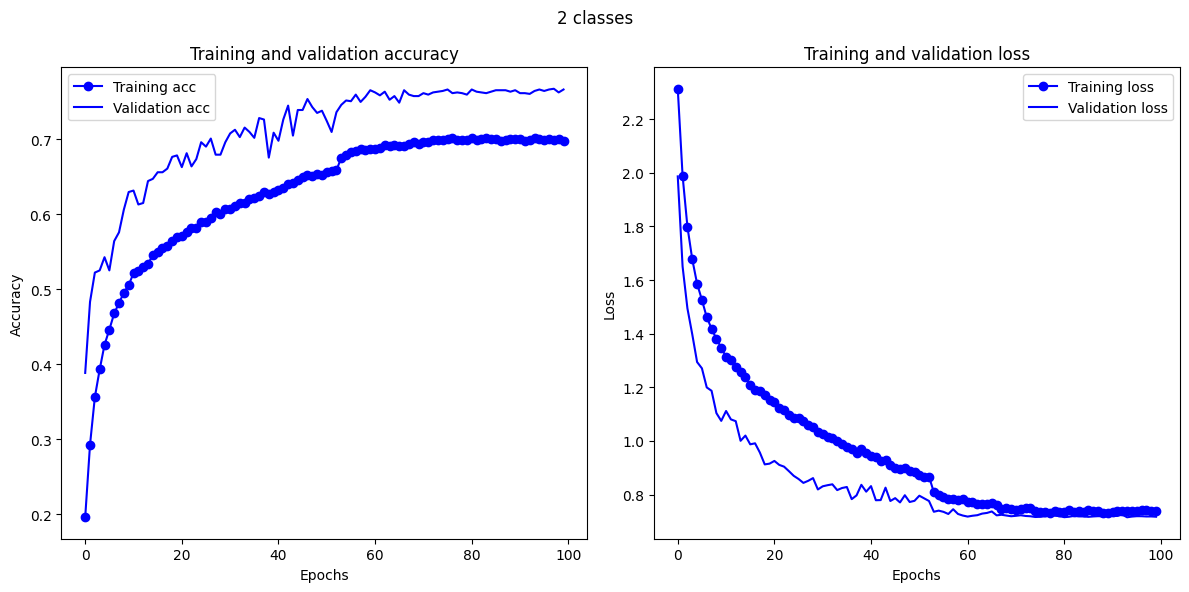

In [ ]:
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model_c.to(device)

best_model = train_and_validate(model_c,
                                train_loader_c,
                                val_loader_c,
                                loss_fn_c,
                                optimizer_c,
                                scheduler_c,
                                num_epochs=75,
                                device=device)

path_model = str("./myModel_best_c.pth")
path = path_model
saveModel(model_c, path=path)



# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, 'bo-', label='Training acc')
plt.plot(val_accuracies, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, 'bo-', label='Training loss')
plt.plot(val_losses, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("2 classes")  # Title for both plots
plt.tight_layout()
plt.show()


**Test**

Loss = 0.8507, F1-Score = 0.7724, Accuracy = 0.7539


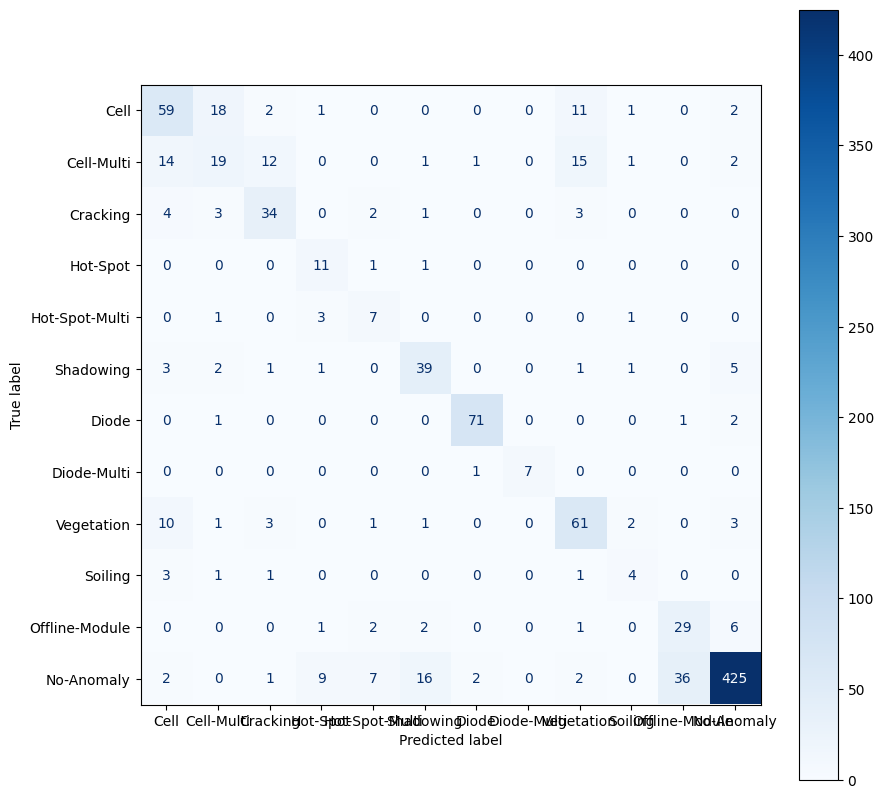

In [ ]:
# Load the model
model_c_test = Network_c()
model_c_test = model_c_test.to(device)
saved_model_path = "./myModel_best_c.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model_c_test.load_state_dict(checkpoint)
model_c_test.eval()

# Perform testing
y_pred_c, test_loss_c, test_acc_c, f1_score_c = test( model=model_c_test,
                                                      dataloader=test_loader_c,
                                                      loss_fn=loss_fn_c,
                                                      device=device,
                                                      verbatim=True)

# Define the confusion matrix plotting function
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

# Plot the confusion matrix
class_names_c = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module', 'No-Anomaly']
plot_confusion_matrix(test_dataset_c.img_labels, y_pred_c, class_names_c)


#2

## Dataset Augmentation Details

To enhance the dataset and improve model robustness, a series of augmentation transformations were applied to each image in the dataset:

- **Flipping Transformations:** Each image underwent one of three flipping operations:
  - Vertical flip
  - Horizontal flip
  - Combined vertical and horizontal flip

  These operations effectively quadruple the dataset size by introducing variations in orientation.

- **Additional Augmentations:** All original and flipped images were further processed using the following transformations:
  - **Random Rotation:** Applied with a maximum range of $\pm 10^\circ$.
  - **Color Jittering:** Adjustments to brightness and contrast with random variation parameters (brightness and contrast $\pm 20\%$).
  - **Random Cropping:** Images were cropped to target dimensions with optional padding.

This augmentation strategy is designed to introduce variability into the dataset while preserving the essential characteristics of the images, thereby improving the generalization capability of the model.


# 3

Compare the results of your AI-model with at least 1 existing models.

In this case **EfficientNet** model is used.

EfficientNet provides excellent performance, often outperforming models like VGG, ResNet, and MobileNet on standard image classification tasks (even on smaller datasets). It's more efficient and accurate than MobileNet while still being relatively lightweight. You can choose from various versions of EfficientNet (like EfficientNet-B0, B1, B2, etc.) depending on your trade-off between speed and accuracy.

When to Use:

If you want a highly efficient model with state-of-the-art performance that can give you good accuracy without requiring extensive computational resources.
If your goal is to balance accuracy and resource usage (without compromising too much on either), EfficientNet is an excellent choice, especially for small image sizes like 40x24.

## a)

**Label assigment and data split**

In [ ]:
df_binary = df.copy()

# Substitution of the labels: anomaly->1 and no_anomaly->0
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

print(df_binary.tail(4))
print("\nDataset size:", df_binary.shape[0])

# Train/Test ratio
train_ratio_3a = 0.8
train_data_3a, test_data_3a = train_test_split(df_binary, test_size=(1-train_ratio_3a), train_size=train_ratio_3a, random_state=11, stratify=df_binary['anomaly_class'])

train_data_3a.reset_index(drop=True, inplace=True)
test_data_3a.reset_index(drop=True, inplace=True)


         image_filepath  anomaly_class
8489    images/8489.jpg              1
7464    images/7464.jpg              1
18065  images/18065.jpg              0
13354  images/13354.jpg              0

Dataset size: 20000


**Dataset class**

In [ ]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horizontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                          # Random rotation of 10 degrees
    transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Data Augmentation**

In [ ]:
# Initial dataset size
train_data_3a_counts = train_data_3a['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_3a_counts)
print("\nInitial Size:", len(train_data_3a), "\n")

train_data_3a_balanced = train_data_3a.copy()

# Folder creation for new images
directory = "/content/images_3a"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data_3a)):
    row = train_data_3a.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    # Perform augmentations
    for n in range(3):
        if(n==0):
          transform_augmentation = transform_augmentation_1
        if(n==1):
          transform_augmentation = transform_augmentation_2
        if(n==2):
          transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3a_balanced = pd.concat([train_data_3a_balanced, pd.DataFrame([new_row])], ignore_index=True)

# Final dataset size
train_data_3a_balanced_counts = train_data_3a_balanced['anomaly_class'].value_counts()
print("\n\nCount of each anomaly type(Augmented):")
print(train_data_3a_balanced_counts)
print("\nAugmented Size:", len(train_data_3a_balanced))

Counts of each anomaly type(Initial):
anomaly_class
1    8000
0    8000
Name: count, dtype: int64

Initial Size: 16000 



Count of each anomaly type(Augmented):
anomaly_class
1    32000
0    32000
Name: count, dtype: int64

Augmented Size: 64000


**Data Loaders**

In [ ]:
# DataLoaders
train_dataset_3a_balanced = MyImageDataset(metadata=train_data_3a_balanced, transform=train_transform)
test_dataset_3a = MyImageDataset(metadata=test_data_3a, transform=test_transform)

#Batch size
batch_size_3a = 32
train_loader_3a = data.DataLoader(dataset=train_dataset_3a_balanced, batch_size=batch_size_3a, shuffle=True)
test_loader_3a = data.DataLoader(dataset=test_dataset_3a, batch_size=batch_size_3a, shuffle=False)

Image Size:  torch.Size([1, 224, 224])


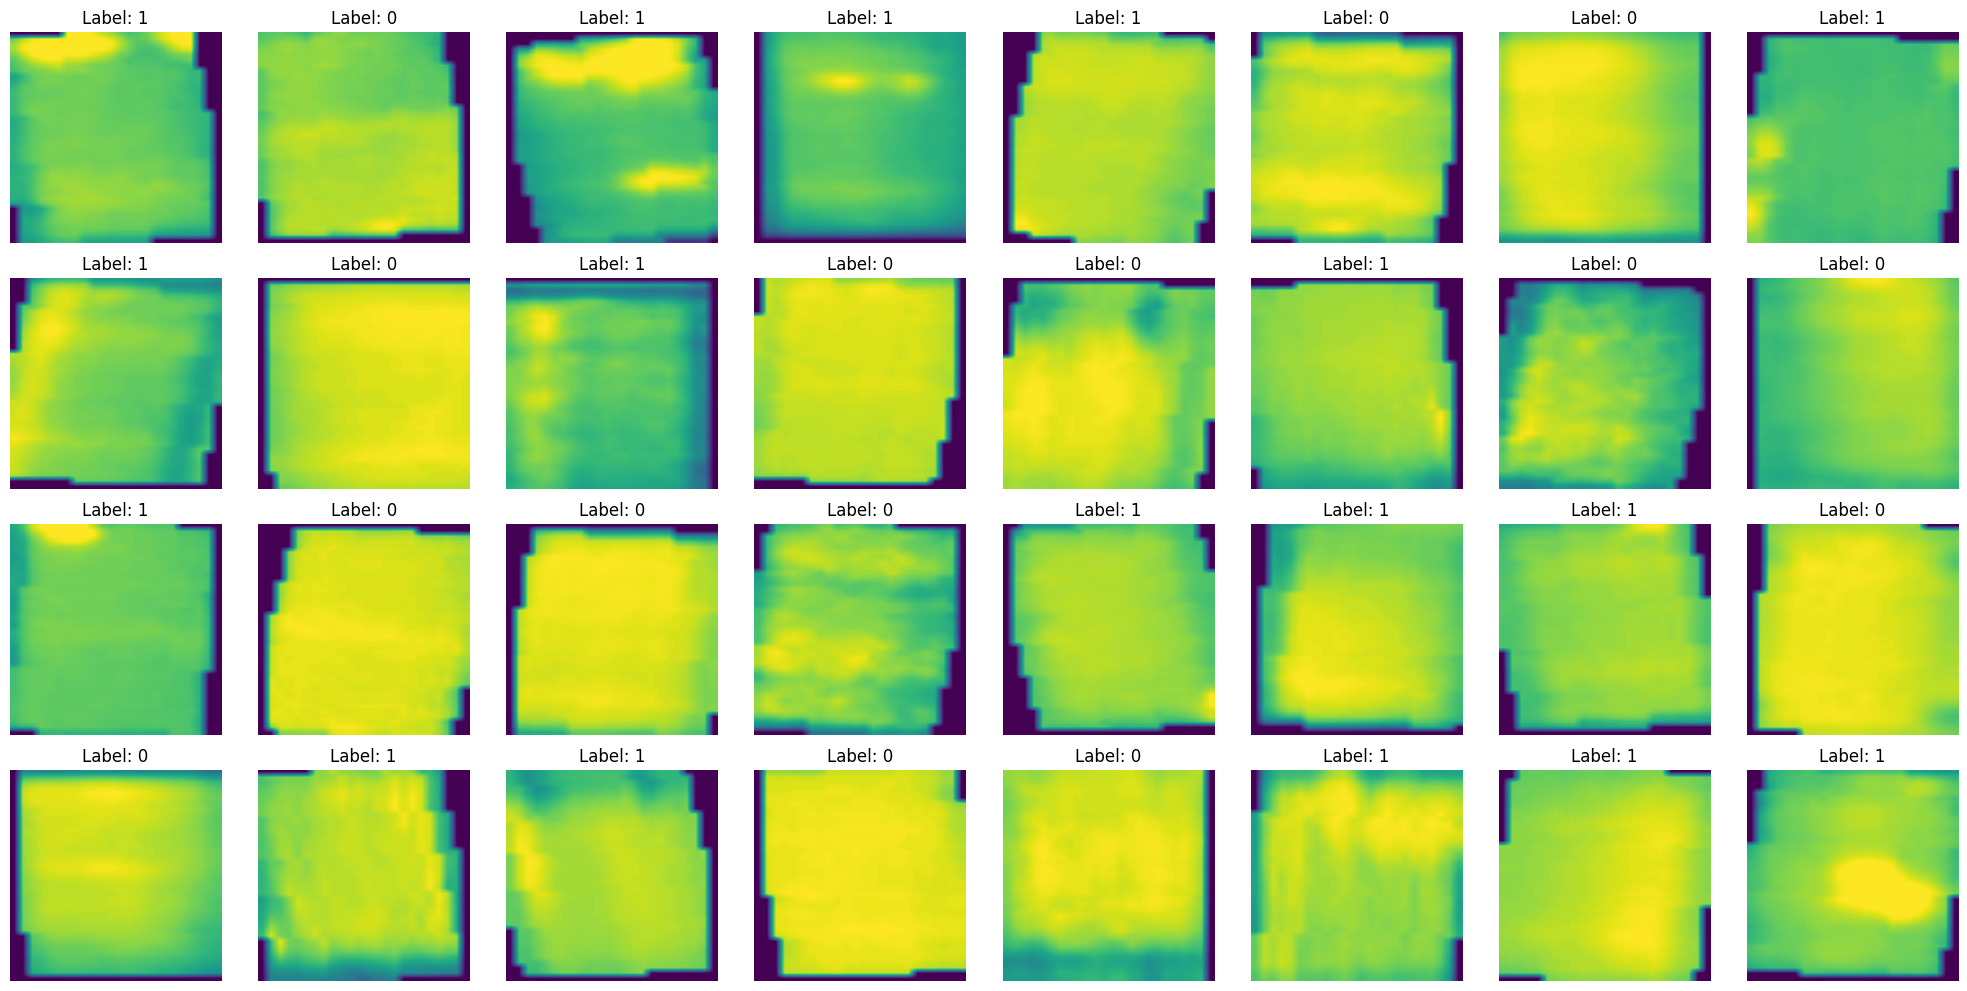

In [ ]:
# Show of 32 images
images, labels = next(iter(train_loader_3a))

# Inverse of normalization
images = images * 0.5 + 0.5
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images)):
    image = images[i]
    image_pil = transforms.ToPILImage()(image)

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

print("Image Size: ", images[0].shape)
plt.tight_layout()
plt.show()

**EficientNet Model**

In [ ]:
efficientnet_model_3a = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the first convolutional layer to accept grayscale images (1 channel)
# EfficientNet expects 3 channels, so we modify the first conv layer to accept 1 channel input
efficientnet_model_3a._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final classification layer for 2 classes
efficientnet_model_3a._fc = nn.Linear(efficientnet_model_3a._fc.in_features, 2)

# Send the model to the device (GPU or CPU)
efficientnet_model_3a = efficientnet_model_3a.to(device)

# Compute class weights based on class distribution
class_labels = train_data_3a_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function and optimizer
loss_fn_efficientnet_3a = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer_efficientnet_3a = optim.Adam(efficientnet_model_3a.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_efficientnet_3a = ReduceLROnPlateau(optimizer_efficientnet_3a, mode='min', factor=0.1, patience=5)


Loaded pretrained weights for efficientnet-b0


**EfficientNet train function**

In [ ]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    avg_loss = train_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

**EfficientNet test function**

In [ ]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = test_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, y_true, y_pred

**EfficientNet train loop**

In [ ]:
# Training loop
import time

num_epochs = 15
best_accuracy = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(efficientnet_model_3a, train_loader_3a, loss_fn_efficientnet_3a, optimizer_efficientnet_3a, device)
    test_loss, test_accuracy, _, _ = test(efficientnet_model_3a, test_loader_3a, loss_fn_efficientnet_3a, device)

    # Step scheduler
    scheduler_efficientnet_3a.step(test_loss)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(efficientnet_model_3a.state_dict(), "efficientnet_best_model_3a.pth")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch time: {epoch_time:.2f} seconds\n")

Epoch 1/15
Train Loss: 0.3605, Train Accuracy: 0.8432
Test Loss: 0.2598, Test Accuracy: 0.8948
Epoch time: 540.09 seconds

Epoch 2/15
Train Loss: 0.2780, Train Accuracy: 0.8874
Test Loss: 0.2070, Test Accuracy: 0.9220
Epoch time: 530.16 seconds

Epoch 3/15
Train Loss: 0.2411, Train Accuracy: 0.9031
Test Loss: 0.1845, Test Accuracy: 0.9320
Epoch time: 535.19 seconds

Epoch 4/15
Train Loss: 0.2184, Train Accuracy: 0.9140
Test Loss: 0.1638, Test Accuracy: 0.9390
Epoch time: 534.11 seconds

Epoch 5/15
Train Loss: 0.2028, Train Accuracy: 0.9210
Test Loss: 0.1815, Test Accuracy: 0.9310
Epoch time: 533.92 seconds

Epoch 6/15
Train Loss: 0.1912, Train Accuracy: 0.9254
Test Loss: 0.1639, Test Accuracy: 0.9420
Epoch time: 533.12 seconds

Epoch 7/15
Train Loss: 0.1828, Train Accuracy: 0.9288
Test Loss: 0.1656, Test Accuracy: 0.9383
Epoch time: 521.46 seconds

Epoch 8/15
Train Loss: 0.1736, Train Accuracy: 0.9338
Test Loss: 0.1510, Test Accuracy: 0.9460
Epoch time: 520.79 seconds

Epoch 9/15
Train

**EfficientNet test and confusion matrix**

<ipython-input-21-ae072561adf2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model_3a.load_state_dict(torch.load("efficientnet_best_model_3a.pth"))


EfficientNet Test Accuracy: 0.954

Confusion Matrix for EfficientNet:


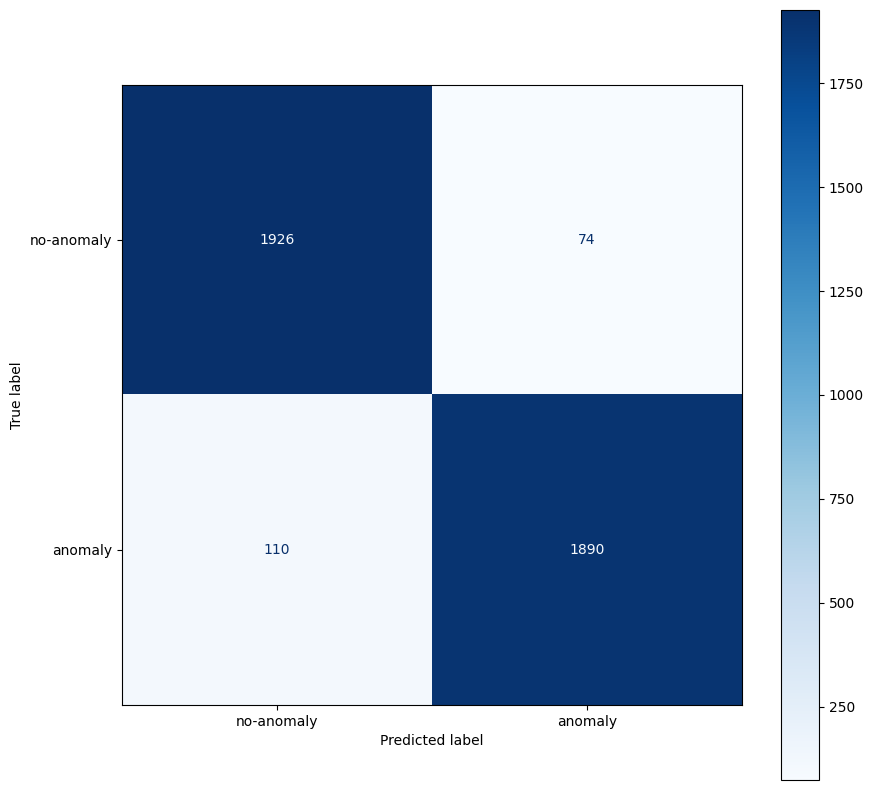

In [ ]:
# Load the best model
efficientnet_model_3a.load_state_dict(torch.load("efficientnet_best_model_3a.pth"))

# Test the model
test_loss_efficientnet_3a, test_accuracy_efficientnet_3a, y_true_efficientnet_3a, y_pred_efficientnet_3a = test(
    efficientnet_model_3a, test_loader_3a, loss_fn_efficientnet_3a, device
)

print("EfficientNet Test Accuracy:", test_accuracy_efficientnet_3a)

# Function to plot confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_3a = ['no-anomaly', 'anomaly']

# Plot confusion matrix for EfficientNet
print("\nConfusion Matrix for EfficientNet:")
plot_confusion_matrix(y_true_efficientnet_3a, y_pred_efficientnet_3a, class_names_3a)

## b)

**Label assigment and data split**

In [ ]:
df_anomaly = df.copy()

# Filter out the "No-Anomaly" class
df_anomaly = df_anomaly[df_anomaly["anomaly_class"] != "No-Anomaly"]

# Substitution of label to a number
df_anomaly['anomaly_class'] = df_anomaly['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)

# Print the class distribution
anomaly_counts = df_anomaly['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(anomaly_counts)

train_ratio_3b = 0.9
train_data_3b, test_data_3b = train_test_split(df_anomaly, test_size=(1 - train_ratio_3b), train_size=train_ratio_3b, random_state=2, stratify=df_anomaly['anomaly_class'])

train_data_3b.reset_index(drop=True, inplace=True)
test_data_3b.reset_index(drop=True, inplace=True)

**Transformations**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical and horizontal flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                          # Random 10 degrees rotation
    transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Data Augmentation**

In [ ]:
train_data_3b_counts = train_data_3b['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_3b_counts)
print("\nInitial Size:", len(train_data_3b), "\n")

train_data_3b_balanced = train_data_3b.copy()

largest_class_count = train_data_3b_counts.max()                  #
ratios = largest_class_count / train_data_3b_counts               #
max_ratio = 4                                                    #
ratios = np.minimum(ratios, max_ratio)                           #
ratios_sorted = ratios.sort_index()                              #
ratios_matrix=[]                                                 # Ratios Calculations
                                                                 #
for label, ratio in ratios_sorted.items():                       #
    ratios_matrix.append([label, ratio])                         #
ratios_matrix[0][1]+=0.1                                         #
print(ratios_matrix)                                             #



directory = "/content/images_3b"                                  #
if os.path.exists(directory):                                    #
    for filename in os.listdir(directory):                       #
        file_path = os.path.join(directory, filename)            #
        try:                                                     #
            if os.path.isdir(file_path):                         #
              shutil.rmtree(file_path)                           # Folder creation for new images
            else:                                                #
                os.remove(file_path)                             #
        except Exception as e:                                   #
            print(f"Error deleting file {file_path}: {e}")       #
else:                                                            #
    os.makedirs(directory, exist_ok=True)                        #


#Augmentation
for i in range(len(train_data_3b)):
    row = train_data_3b.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        random_number = random.randint(1, 3)
        if(int_part==1):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==0):
            if(num1==1):
                transform_augmentation = transform_augmentation_1
            elif(num1==2):
                transform_augmentation = transform_augmentation_2
            elif(num1==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==1):
            if(num2==1):
                transform_augmentation = transform_augmentation_1
            elif(num2==2):
                transform_augmentation = transform_augmentation_2
            elif(num2==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==3 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==3 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==3 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==4 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==4 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==3):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3b_balanced = pd.concat([train_data_3b_balanced, pd.DataFrame([new_row])], ignore_index=True)

    # Perform probabilistic augmentation for the fractional part
    if random.random() < frac_part:
        random_number = random.randint(1, 3)
        if(random_number==1):
            transform_augmentation = transform_augmentation_1
        elif(random_number==2):
            transform_augmentation = transform_augmentation_2
        elif(random_number==3):
            transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        x=1
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_2_{int(label)}_{i}_{x}.jpg")
        x+=1
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3b_balanced = pd.concat([train_data_3b_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_3b_balanced_counts = train_data_3b_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_3b_balanced_counts)
print("\nAugmented Size:", len(train_data_3b_balanced))

**Dataset Class**

In [ ]:
class MyImageDataset_3b(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Train and test data loaders**

In [ ]:
train_dataset_3b_balanced = MyImageDataset_3b(metadata=train_data_3b_balanced, transform=train_transform)
test_dataset_3b = MyImageDataset_3b(metadata=test_data_3b, transform=test_transform)

#Batch size
batch_size = 32
train_loader_3b = data.DataLoader(dataset=train_dataset_3b_balanced, batch_size=batch_size, shuffle=True)
test_loader_3b = data.DataLoader(dataset=test_dataset_3b, batch_size=batch_size, shuffle=False)

In [ ]:
# Show a batch
images_3b, labels_3b = next(iter(train_loader_3b))
print(labels_3b[0])

images_3b = images_3b * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_3b)):
    image = images_3b[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_3b[i].item()}")
    axes[i].axis('off')
print(images_3b[0].shape)
plt.tight_layout()
plt.show()

**EfficientNet Model**

In [ ]:
efficientnet_model_3b = EfficientNet.from_pretrained('efficientnet-b0')

# EfficientNet expects 3 channels, so modify the first conv layer to accept 1 channel input
efficientnet_model_3b._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final classification layer for 11 classes
efficientnet_model_3b._fc = nn.Linear(efficientnet_model_3b._fc.in_features, 11)

efficientnet_model_3b = efficientnet_model_3b.to(device)

class_labels = train_data_3b_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function and optimizer
loss_fn_efficientnet_3b = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer_efficientnet_3b = optim.Adam(efficientnet_model_3b.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_efficientnet_3b = ReduceLROnPlateau(optimizer_efficientnet_3b, mode='min', factor=0.1, patience=5)


**EfficientNet train function**

In [ ]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    avg_loss = train_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

**EfficientNet test function**

In [ ]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = test_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, y_true, y_pred

**EfficientNet training loop**

In [ ]:
# Training loop
import time

num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(efficientnet_model_3b, train_loader_3b, loss_fn_efficientnet_3b, optimizer_efficientnet_3b, device)
    test_loss, test_accuracy, _, _ = test(efficientnet_model_3b, test_loader_3b, loss_fn_efficientnet_3b, device)

    # Step scheduler
    scheduler_efficientnet_3b.step(test_loss)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(efficientnet_model_3b.state_dict(), "efficientnet_best_model_3b.pth")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch time: {epoch_time:.2f} seconds\n")

**EfficientNet test and confusion matrix**

In [ ]:
# Load the best model
efficientnet_model_3b.load_state_dict(torch.load("efficientnet_best_model_3b.pth"))

# Test the model
test_loss_efficientnet_3b, test_accuracy_efficientnet_3b, y_true_efficientnet_3b, y_pred_efficientnet_3b = test(
    efficientnet_model_3b, test_loader_3b, loss_fn_efficientnet_3b, device
)

print("EfficientNet Test Accuracy:", test_accuracy_efficientnet_3b)

# Function to plot confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_3b = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module']

# Plot confusion matrix for EfficientNet
print("\nConfusion Matrix for EfficientNet:")
plot_confusion_matrix(y_true_efficientnet_3b, y_pred_efficientnet_3b, class_names_3b)

## c)

**Label assigment and data split**

In [ ]:
# Binary Classification DataFrame
df_all_classes = df.copy()

# Substitution of string lables to numeric
df_all_classes['anomaly_class'] = df_all_classes['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)

# Class distribution
df_all_classes_count = df_all_classes['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(df_all_classes_count)

#Train/Test ratio and split
train_ratio_3 = 0.9
train_data_3, test_data_3 = train_test_split(df_all_classes, test_size=(1 - train_ratio_3), train_size=train_ratio_3, random_state=2, stratify=df_all_classes['anomaly_class'])

train_data_3.reset_index(drop=True, inplace=True)
test_data_3.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
11    10000
0      1877
8      1639
6      1499
1      1288
5      1056
2       940
10      827
3       249
4       246
9       204
7       175
Name: count, dtype: int64


**Transformations**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horzontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                            # Random 10 degrees rotation
    #transforms.RandomCrop((40, 24), padding=1),              # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),     # Color jitter
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                    # Conversion to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])               # Normalization
])

# Test Transfomr
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                    # Conversion to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])               # Normalization
])

**Data Augmentation**

In [ ]:
train_data_3_counts = train_data_3['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_3_counts)
print("\nInitial Size:", len(train_data_3), "\n")

# Datasets
train_data_3_balanced = train_data_3.copy()

largest_class_count = train_data_3_counts.max()                     #
ratios = largest_class_count / train_data_3_counts                  #
max_ratio = 4                                                       #
ratios = np.minimum(ratios, max_ratio)                              #
ratios_sorted = ratios.sort_index()                                 # Ratios Calculations
ratios_matrix=[]                                                    #
for label, ratio in ratios_sorted.items():                          #
    ratios_matrix.append([label, ratio])                            #
print(ratios_matrix)                                                #



directory = "/content/images_3"                                     #
if os.path.exists(directory):                                       #
    for filename in os.listdir(directory):                          #
        file_path = os.path.join(directory, filename)               #
        try:                                                        #
            if os.path.isdir(file_path):                            #
                shutil.rmtree(file_path)                            # Folder creation for new images
            else:                                                   #
                os.remove(file_path)                                #
        except Exception as e:                                      #
            print(f"Error deleting file {file_path}: {e}")          #
else:                                                               #
    os.makedirs(directory, exist_ok=True)                           #


# Augmentation
for i in range(len(train_data_3)):
    row = train_data_3.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        if(n==0):
            transform_augmentation = transform_augmentation_1
        elif(n==1):
            transform_augmentation = transform_augmentation_2
        elif(n==2):
            transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3_balanced = pd.concat([train_data_3_balanced, pd.DataFrame([new_row])], ignore_index=True)

train_data_3_balanced_counts = train_data_3_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_3_balanced_counts)
print("\nAugmented Size:", len(train_data_3_balanced))

Counts of each anomaly type(Initial):
anomaly_class
11    9000
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64

Initial Size: 18000 

[[0, 4.0], [1, 4.0], [2, 4.0], [3, 4.0], [4, 4.0], [5, 4.0], [6, 4.0], [7, 4.0], [8, 4.0], [9, 4.0], [10, 4.0], [11, 1.0]]


Counts of each anomaly type(Augmented):
anomaly_class
11    9000
0     6756
8     5900
6     5396
1     4636
5     3800
2     3384
10    2976
3      896
4      888
9      736
7      632
Name: count, dtype: int64

Augmented Size: 45000


**Dataset class**

In [ ]:
class MyImageDataset_c(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Train and test data loaders**

In [ ]:
# DataLoaders
train_dataset_3_balanced = MyImageDataset_c(metadata=train_data_3_balanced, transform=train_transform)
test_dataset_3 = MyImageDataset_c(metadata=test_data_3, transform=test_transform)

batch_size = 32
train_loader_3 = data.DataLoader(dataset=train_dataset_3_balanced, batch_size=batch_size, shuffle=True)
test_loader_3 = data.DataLoader(dataset=test_dataset_3, batch_size=batch_size, shuffle=False)

Image size torch.Size([1, 224, 224])


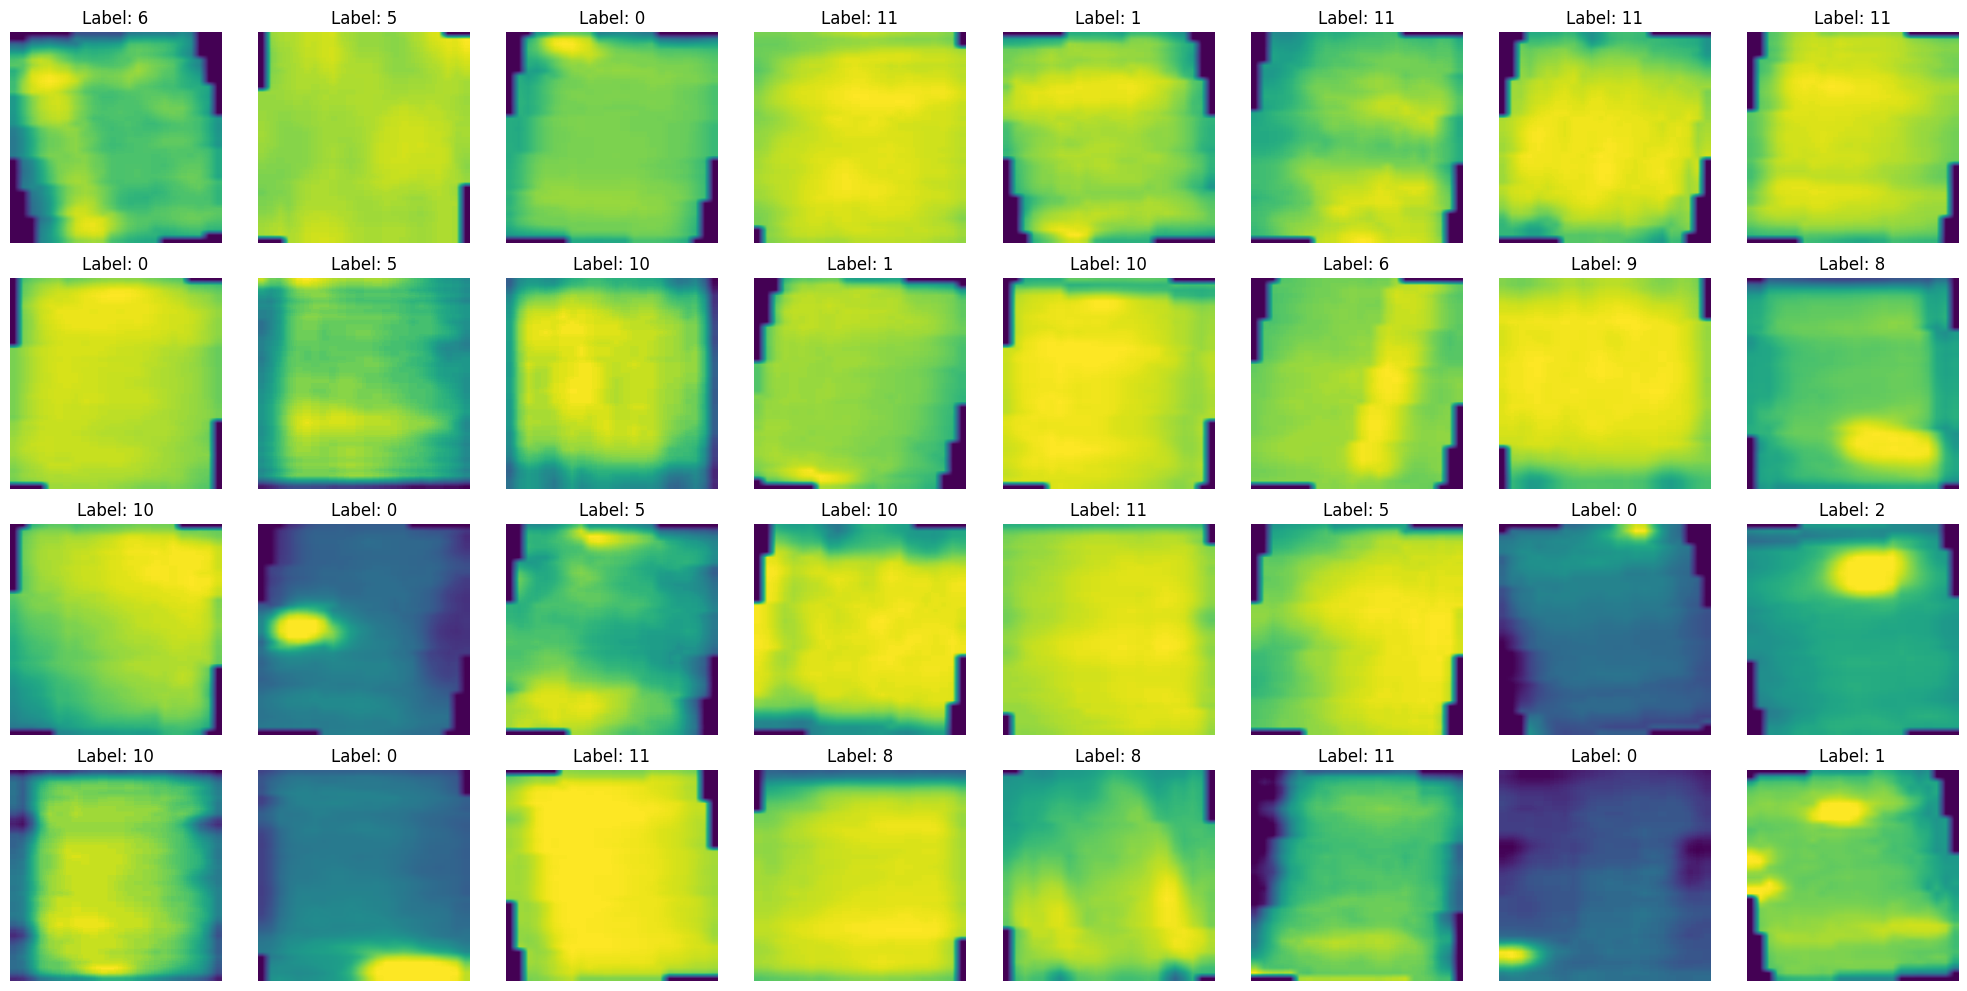

In [ ]:
# Show of a batch
images_3, labels_3 = next(iter(train_loader_3))
images_3 = images_3 * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_3)):
    image = images_3[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_3[i].item()}")
    axes[i].axis('off')

print("Image size", images_3[0].shape)
plt.tight_layout()
plt.show()

**EfficientNet Model**

In [ ]:
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the first convolutional layer to accept grayscale images (1 channel)
# EfficientNet expects 3 channels, so we modify the first conv layer to accept 1 channel input
efficientnet_model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final classification layer for 12 classes
efficientnet_model._fc = nn.Linear(efficientnet_model._fc.in_features, 12)

# Send the model to the device (GPU or CPU)
efficientnet_model = efficientnet_model.to(device)

# Compute class weights based on class distribution
class_labels = train_data_3_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function and optimizer
loss_fn_efficientnet = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_efficientnet = ReduceLROnPlateau(optimizer_efficientnet, mode='min', factor=0.1, patience=5)


Loaded pretrained weights for efficientnet-b0


**EfficientNet train function**

In [ ]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    avg_loss = train_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

**EfficientNet test function**

In [ ]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = test_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, y_true, y_pred

**EfficientNet training loop**

In [ ]:
# Training loop
import time

num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(efficientnet_model, train_loader_3, loss_fn_efficientnet, optimizer_efficientnet, device)
    test_loss, test_accuracy, _, _ = test(efficientnet_model, test_loader_3, loss_fn_efficientnet, device)

    # Step scheduler
    scheduler_efficientnet.step(test_loss)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(efficientnet_model.state_dict(), "efficientnet_best_model_gray.pth")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch time: {epoch_time:.2f} seconds\n")

Epoch 1/20
Train Loss: 1.5000, Train Accuracy: 0.4738
Test Loss: 1.0484, Test Accuracy: 0.6945
Epoch time: 355.06 seconds

Epoch 2/20
Train Loss: 1.0135, Train Accuracy: 0.6347
Test Loss: 0.8616, Test Accuracy: 0.7310
Epoch time: 352.75 seconds

Epoch 3/20
Train Loss: 0.8543, Train Accuracy: 0.6877
Test Loss: 0.7911, Test Accuracy: 0.7495
Epoch time: 352.99 seconds

Epoch 4/20
Train Loss: 0.7428, Train Accuracy: 0.7223
Test Loss: 0.7674, Test Accuracy: 0.7800
Epoch time: 353.06 seconds

Epoch 5/20
Train Loss: 0.6656, Train Accuracy: 0.7439
Test Loss: 0.7100, Test Accuracy: 0.7970
Epoch time: 352.84 seconds

Epoch 6/20
Train Loss: 0.5979, Train Accuracy: 0.7645
Test Loss: 0.6894, Test Accuracy: 0.8140
Epoch time: 352.93 seconds

Epoch 7/20
Train Loss: 0.5444, Train Accuracy: 0.7821
Test Loss: 0.7510, Test Accuracy: 0.8050
Epoch time: 352.66 seconds

Epoch 8/20
Train Loss: 0.4896, Train Accuracy: 0.7995
Test Loss: 0.7695, Test Accuracy: 0.8070
Epoch time: 352.11 seconds

Epoch 9/20
Train

**EfficientNet test and confusion matrix**

In [ ]:
# Load the best model
efficientnet_model.load_state_dict(torch.load("efficientnet_best_model_gray.pth"))

# Test the model
test_loss_efficientnet, test_accuracy_efficientnet, y_true_efficientnet, y_pred_efficientnet = test(
    efficientnet_model, test_loader_3, loss_fn_efficientnet, device
)

print("EfficientNet Test Accuracy:", test_accuracy_efficientnet)

<ipython-input-26-82fdbb6f0333>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model.load_state_dict(torch.load("efficientnet_best_model_gray.pth"))


EfficientNet Test Accuracy: 0.8415



Confusion Matrix for EfficientNet:


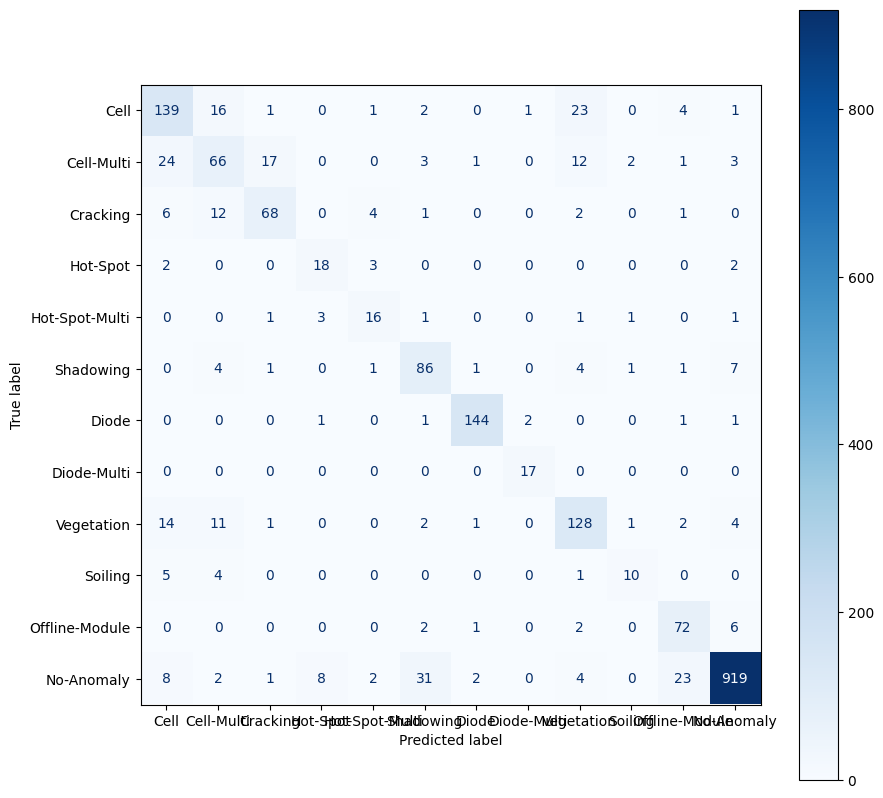

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_c = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module', 'No-Anomaly']

# Plot confusion matrix for EfficientNet
print("\nConfusion Matrix for EfficientNet:")
plot_confusion_matrix(y_true_efficientnet, y_pred_efficientnet, class_names_c)